In [1]:
# Built-in python libraries
import os
import re

# General libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Preprocessing and training libraries
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler
import gower
import warnings
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import chi2_contingency
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_pca_correlation_graph
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D
import warnings

# Suppress all FutureWarnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# Custom Setup
%matplotlib inline
sns.set(style='darkgrid')
sns.set_theme(context='notebook', style='darkgrid', palette='husl')
pd.set_option('display.max_columns', None) # display all columns in pandas

# EDA

Import data

In [2]:
df = pd.read_csv(r"diabetic_data.csv", na_values='?',low_memory=False) # make ?? as nan
# Example: Take 20% of the dataset
df = df.sample(frac=0.01, random_state=42)
print("The shape of the dataset is {}.\n\n".format(df.shape))

df.head()

The shape of the dataset is (1018, 50).




encounter_id  patient_nbr             race  gender      age weight  \
35956     110939484     19274094        Caucasian  Female  [70-80)    NaN   
60927     170328306     65634327        Caucasian    Male  [50-60)    NaN   
79920     245688426    100657359        Caucasian  Female  [60-70)    NaN   
50078     150826224     83144448        Caucasian    Male  [30-40)    NaN   
44080     135993852     65234214  AfricanAmerican  Female  [60-70)    NaN   

       admission_type_id  discharge_disposition_id  admission_source_id  \
35956                  1                         1                    6   
60927                  1                         1                    1   
79920                  3                         6                    1   
50078                  2                         1                    1   
44080                  1                         2                    7   

       time_in_hospital payer_code medical_specialty  num_lab_procedures  \
35956                11         UN  InternalMedicine                  68   
60927                 1         HM               NaN                  20   
79920                 4         HM               NaN                  21   
50078                12         CP  Gastroenterology                  28   
44080                 1        NaN               NaN                  21   

       num_procedures  num_medications  number_outpatient  number_emergency  \
35956               0               20                  0                 0   
60927               0                7                  0                 0   
79920               3               23                  1                 0   
50078               0               19                  0                 0   
44080               0                6                  0                 0   

       number_inpatient diag_1 diag_2 diag_3  number_diagnoses max_glu_serum  \
35956                 0  250.8    599    263                 5           NaN   
60927                 0    780    427   E941                 8           NaN   
79920                 2    715    733    724                 7           NaN   
50078                 1    494    277    117                 7           NaN   
44080                 0    403    584    428                 7           NaN   

      A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride  \
35956       NaN        No          No          No             No          No   
60927       NaN    Steady          No          No             No          No   
79920       NaN    Steady          No          No             No          No   
50078       NaN        No          No          No             No          No   
44080       NaN        No          No          No             No          No   

      acetohexamide glipizide glyburide tolbutamide pioglitazone  \
35956            No        No        No          No           No   
60927            No        No        No          No           No   
79920            No        No        No          No           No   
50078            No        No        No          No       Steady   
44080            No    Steady        No          No           No   

      rosiglitazone acarbose miglitol troglitazone tolazamide examide  \
35956            No       No       No           No         No      No   
60927            No       No       No           No         No      No   
79920            No       No       No           No         No      No   
50078            No       No       No           No         No      No   
44080            No       No       No           No         No      No   

      citoglipton insulin glyburide-metformin glipizide-metformin  \
35956          No  Steady                  No                  No   
60927          No      No                  No                  No   
79920          No      No                  No                  No   
50078          No      No                  No                  No   
44080 

In [3]:
# Load the dataset
df = pd.read_csv(r"diabetic_data.csv", na_values='?', low_memory=False)  # Treat '?' as NaN
print(f"Original shape of the dataset: {df.shape}")

df = df.sample(frac=0.05, random_state=42)


# Convert the `readmitted` column into numeric form (if not already done)
readmitted_mapping = {'NO': 0, '<30': 2, '>30': 1}  # Example mapping
df['readmitted'] = df['readmitted'].map(readmitted_mapping)

# Drop any rows with missing values in 'readmitted_numeric' or other columns of interest
df = df.dropna(subset=['readmitted'])
print(f"Dataset shape after dropping missing 'readmitted': {df.shape}")

# Determine the class with the smallest number of samples (minority class)
class_counts = df['readmitted'].value_counts()
minority_class_size = class_counts.min()
print(f"Minority class size: {minority_class_size}")

# Downsample each class to the size of the minority class
balanced_dfs = []
for class_label, count in class_counts.items():
    class_subset = df[df['readmitted'] == class_label]
    downsampled_class = class_subset.sample(n=minority_class_size, random_state=42)
    balanced_dfs.append(downsampled_class)

# Combine the downsampled classes into a single balanced dataset
balanced_df = pd.concat(balanced_dfs, axis=0).reset_index(drop=True)

print(f"Shape of the balanced dataset: {balanced_df.shape}")
print(balanced_df['readmitted'].value_counts())

# Optional: Sample a smaller fraction of the balanced dataset (if needed for performance)
#df = balanced_df.sample(frac=0.01, random_state=42)
print(f"Shape of the downsampled balanced dataset: {balanced_df.shape}")

# Display the first few rows
balanced_df.head()


Original shape of the dataset: (101766, 50)
Dataset shape after dropping missing 'readmitted': (5088, 50)
Minority class size: 583
Shape of the balanced dataset: (1749, 50)
readmitted
0    583
1    583
2    583
Name: count, dtype: int64
Shape of the downsampled balanced dataset: (1749, 50)


encounter_id  patient_nbr             race  gender      age weight  \
0      16202532      7113789         Hispanic  Female  [50-60)    NaN   
1     116393658     23245515        Caucasian  Female  [70-80)    NaN   
2     252466428     47360421        Caucasian  Female  [50-60)    NaN   
3     104445024     92362221  AfricanAmerican  Female  [70-80)    NaN   
4      71068074      3390930        Caucasian  Female  [60-70)    NaN   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                         1                    7   
1                  3                         3                    1   
2                  3                         1                    1   
3                  6                         1                   17   
4                  1                         3                    5   

   time_in_hospital payer_code           medical_specialty  \
0                 4        NaN                         NaN   
1                 3         MC  Orthopedics-Reconstructive   
2                 1         BC               Ophthalmology   
3                 4        NaN             Surgery-General   
4                 2        NaN                         NaN   

   num_lab_procedures  num_procedures  num_medications  number_outpatient  \
0                  52               0                8                  0   
1                  39               1               33                  0   
2                   1               1                8                  0   
3                  55               3               21                  0   
4                  60               0               15                  0   

   number_emergency  number_inpatient diag_1 diag_2 diag_3  number_diagnoses  \
0                 0                 0    786    250    401                 3   
1                 0                 1    715    250    414                 5   
2                 0                 0    823  250.8    714                 6   
3                 0                 0    996    427    428                 9   
4                 0                 1    786    599    780                 9   

  max_glu_serum A1Cresult metformin repaglinide nateglinide chlorpropamide  \
0          >300        >8        No          No          No             No   
1           NaN       NaN    Steady          No          No             No   
2           NaN       NaN        No          No          No             No   
3           NaN       NaN        No          No          No             No   
4           NaN       NaN        No          No          No             No   

  glimepiride acetohexamide glipizide glyburide tolbutamide pioglitazone  \
0          No            No    Steady        No          No           No   
1          No            No        No    Steady          No           No   
2          No            No        No        No          No           No   
3          No            No        No        No          No           No   
4          No            No    Steady        No          No           No   

  rosiglitazone acarbose miglitol troglitazone tolazamide examide citoglipton  \
0            No       No       No           No         No      No          No   
1            No       No       No           No         No      No          No   
2            No       No       No           No         No      No          No   
3            No       No       No           No         No      No          No   
4            No       No       No           No         No      No          No   

  insulin glyburide-metformin glipizide-metformin glimepiride-pioglitazone  \
0      No                  No                  No                       No   
1  Steady                  No                  No                       No   
2      No                  No                  No                       No   
3      No                  No                  No                       No   
4      No        

In [4]:
X_train = balanced_df.drop(['readmitted'],axis=1)
y_train = balanced_df['readmitted'].copy()

In [5]:
train_data = pd.concat([X_train,y_train], axis=1)
train_data.head()

encounter_id  patient_nbr             race  gender      age weight  \
0      16202532      7113789         Hispanic  Female  [50-60)    NaN   
1     116393658     23245515        Caucasian  Female  [70-80)    NaN   
2     252466428     47360421        Caucasian  Female  [50-60)    NaN   
3     104445024     92362221  AfricanAmerican  Female  [70-80)    NaN   
4      71068074      3390930        Caucasian  Female  [60-70)    NaN   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                         1                    7   
1                  3                         3                    1   
2                  3                         1                    1   
3                  6                         1                   17   
4                  1                         3                    5   

   time_in_hospital payer_code           medical_specialty  \
0                 4        NaN                         NaN   
1                 3         MC  Orthopedics-Reconstructive   
2                 1         BC               Ophthalmology   
3                 4        NaN             Surgery-General   
4                 2        NaN                         NaN   

   num_lab_procedures  num_procedures  num_medications  number_outpatient  \
0                  52               0                8                  0   
1                  39               1               33                  0   
2                   1               1                8                  0   
3                  55               3               21                  0   
4                  60               0               15                  0   

   number_emergency  number_inpatient diag_1 diag_2 diag_3  number_diagnoses  \
0                 0                 0    786    250    401                 3   
1                 0                 1    715    250    414                 5   
2                 0                 0    823  250.8    714                 6   
3                 0                 0    996    427    428                 9   
4                 0                 1    786    599    780                 9   

  max_glu_serum A1Cresult metformin repaglinide nateglinide chlorpropamide  \
0          >300        >8        No          No          No             No   
1           NaN       NaN    Steady          No          No             No   
2           NaN       NaN        No          No          No             No   
3           NaN       NaN        No          No          No             No   
4           NaN       NaN        No          No          No             No   

  glimepiride acetohexamide glipizide glyburide tolbutamide pioglitazone  \
0          No            No    Steady        No          No           No   
1          No            No        No    Steady          No           No   
2          No            No        No        No          No           No   
3          No            No        No        No          No           No   
4          No            No    Steady        No          No           No   

  rosiglitazone acarbose miglitol troglitazone tolazamide examide citoglipton  \
0            No       No       No           No         No      No          No   
1            No       No       No           No         No      No          No   
2            No       No       No           No         No      No          No   
3            No       No       No           No         No      No          No   
4            No       No       No           No         No      No          No   

  insulin glyburide-metformin glipizide-metformin glimepiride-pioglitazone  \
0      No                  No                  No                       No   
1  Steady                  No                  No                       No   
2      No                  No                  No                       No   
3      No                  No                  No                       No   
4      No        

Dividing the columns into categorical, numerical, ID and diag columns.



In [6]:
cat_cols = [
    'race', 'gender', 'age', 'weight', 'admission_type_id',
    'discharge_disposition_id', 'admission_source_id', 'payer_code',
    'medical_specialty', 'max_glu_serum',
    'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
    'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
    'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
    'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin',
    'glipizide-metformin', 'glimepiride-pioglitazone',
    'metformin-rosiglitazone', 'metformin-pioglitazone', 'change',
    'diabetesMed'
]

num_cols = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses'
]

ID_cols = ["encounter_id", "patient_nbr"]

diag_cols = ['diag_1', 'diag_2', 'diag_3']


**Analyze categorical columns**

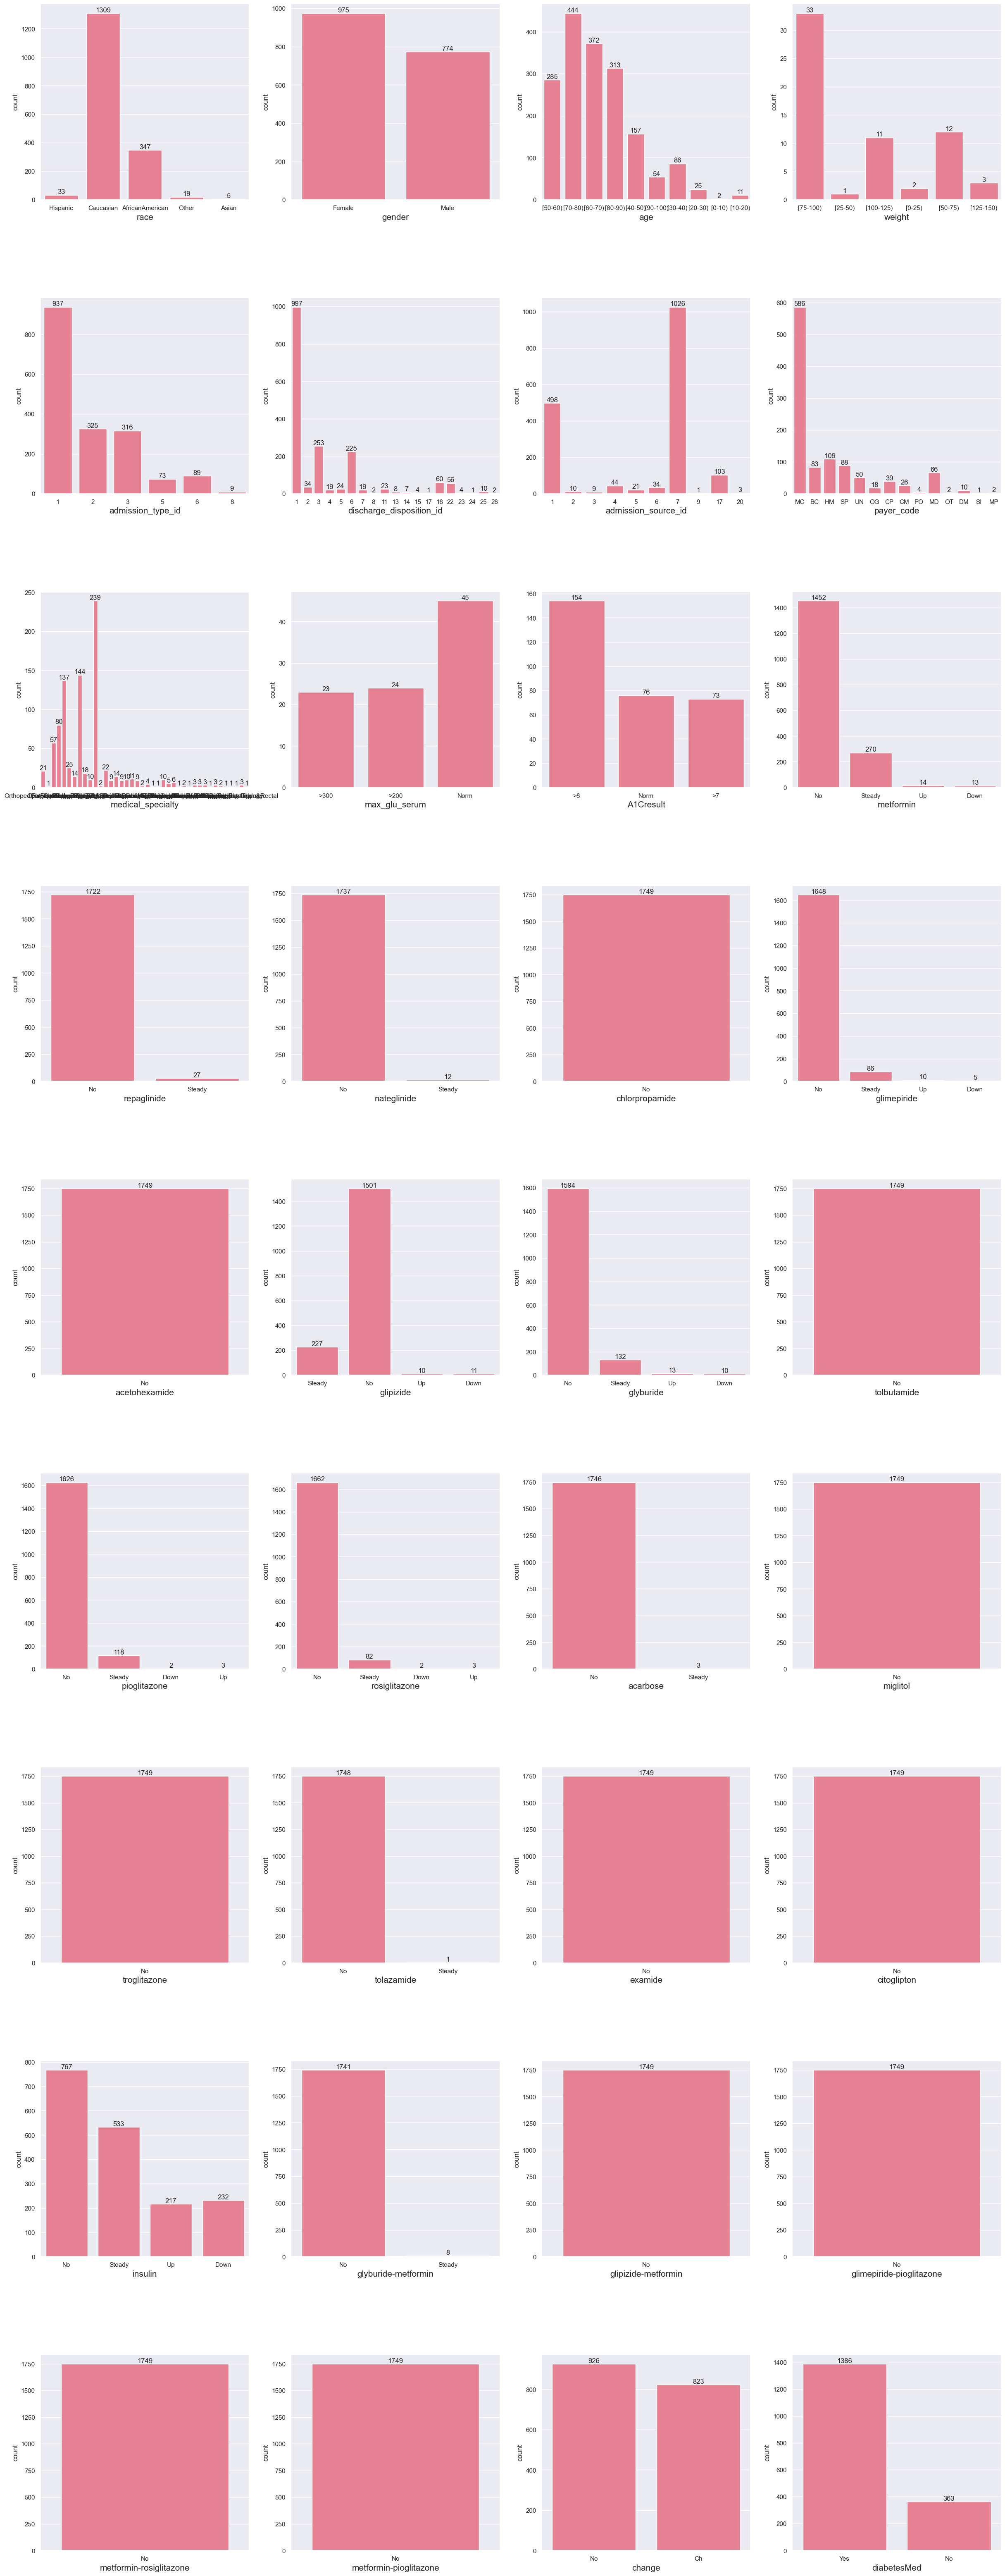

In [7]:
fig, axs = plt.subplots(nrows=9, ncols=4, figsize=(30, 80))
plt.subplots_adjust(hspace=0.5)

for column, ax in zip(cat_cols, axs.ravel()):
    sns.countplot(x=train_data[column], ax=ax)
    ax.set_xlabel(column, fontsize=15)
    for container in ax.containers:
        ax.bar_label(container, fontsize=12)

plt.show()

Remove columns that show no or very low variance, as they don't provide any info. Remove weight and medical_specialty since most values are missing.

We will remove all the columns that have no or very low variance, as they will not give the model any new information.

We will remove the weight and medical_specialty columns because most of them are missing.

So the columns that will be removed are:


In [8]:
cols_to_drop = ['weight','medical_specialty','chlorpropamide','acetohexamide','weight','tolbutamide',
    'acarbose','miglitol','troglitazone','tolazamide','examide','citoglipton',
    'glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone',
    'metformin-rosiglitazone','metformin-pioglitazone']

train_data.drop(cols_to_drop,axis=1)

encounter_id  patient_nbr             race  gender       age  \
0         16202532      7113789         Hispanic  Female   [50-60)   
1        116393658     23245515        Caucasian  Female   [70-80)   
2        252466428     47360421        Caucasian  Female   [50-60)   
3        104445024     92362221  AfricanAmerican  Female   [70-80)   
4         71068074      3390930        Caucasian  Female   [60-70)   
...            ...          ...              ...     ...       ...   
1744     168422370     23308875  AfricanAmerican  Female   [70-80)   
1745      25867422      3244851  AfricanAmerican  Female   [60-70)   
1746       9355386     97847946        Caucasian  Female   [80-90)   
1747     228190254     93617955        Caucasian  Female  [90-100)   
1748     205932234     84624678  AfricanAmerican  Female   [30-40)   

      admission_type_id  discharge_disposition_id  admission_source_id  \
0                     6                         1                    7   
1                     3                         3                    1   
2                     3                         1                    1   
3                     6                         1                   17   
4                     1                         3                    5   
...                 ...                       ...                  ...   
1744                  3                         1                    1   
1745                  1                         5                    7   
1746                  1                         3                    7   
1747                  2                         6                    7   
1748                  3                         1                    1   

      time_in_hospital payer_code  num_lab_procedures  num_procedures  \
0                    4        NaN                  52               0   
1                    3         MC                  39               1   
2                    1         BC                   1               1   
3                    4        NaN                  55               3   
4                    2        NaN                  60               0   
...                ...        ...                 ...             ...   
1744                 5         MC                  18               0   
1745                13        NaN                  32               2   
1746                 5        NaN                  95               5   
1747                 5         SP                  28               0   
1748                 2         MD                  59               0   

      num_medications  number_outpatient  number_emergency  number_inpatient  \
0                   8                  0                 0                 0   
1                  33                  0                 0                 1   
2                   8                  0                 0                 0   
3                  21                  0                 0                 0   
4                  15                  0                 0                 1   
...               ...                ...               ...               ...   
1744               18                  0                 0                 0   
1745               32                  0                 0                 0   
1746               22                  0                 0                 0   
1747                5                  0                 0                 3   
1748                6                  1                 1                 1   

     diag_1  diag_2 diag_3  number_diagnoses max_glu_serum A1Cresult  \
0       786     250    401                 3          >300        >8   
1       715     250    414                 5           NaN       NaN   
2       823   250.8    714                 6           NaN       NaN   
3       996     427    428                 9           NaN       NaN   
4       786     599    780                 9           NaN       NaN   
...   

**Analyze numerical columns**

In [9]:
train_data[num_cols].describe().T


count       mean        std  min   25%   50%   75%    max
time_in_hospital    1749.0   4.578616   2.994316  1.0   2.0   4.0   6.0   14.0
num_lab_procedures  1749.0  44.495140  18.914042  1.0  34.0  45.0  58.0  113.0
num_procedures      1749.0   1.284162   1.686833  0.0   0.0   1.0   2.0    6.0
num_medications     1749.0  16.369354   8.114928  1.0  11.0  15.0  21.0   68.0
number_outpatient   1749.0   0.377358   1.100484  0.0   0.0   0.0   0.0   14.0
number_emergency    1749.0   0.226415   0.892487  0.0   0.0   0.0   0.0   22.0
number_inpatient    1749.0   0.767296   1.425955  0.0   0.0   0.0   1.0   16.0
number_diagnoses    1749.0   7.472842   1.890897  1.0   6.0   9.0   9.0   10.0

Checking the distribution of numerical columns.



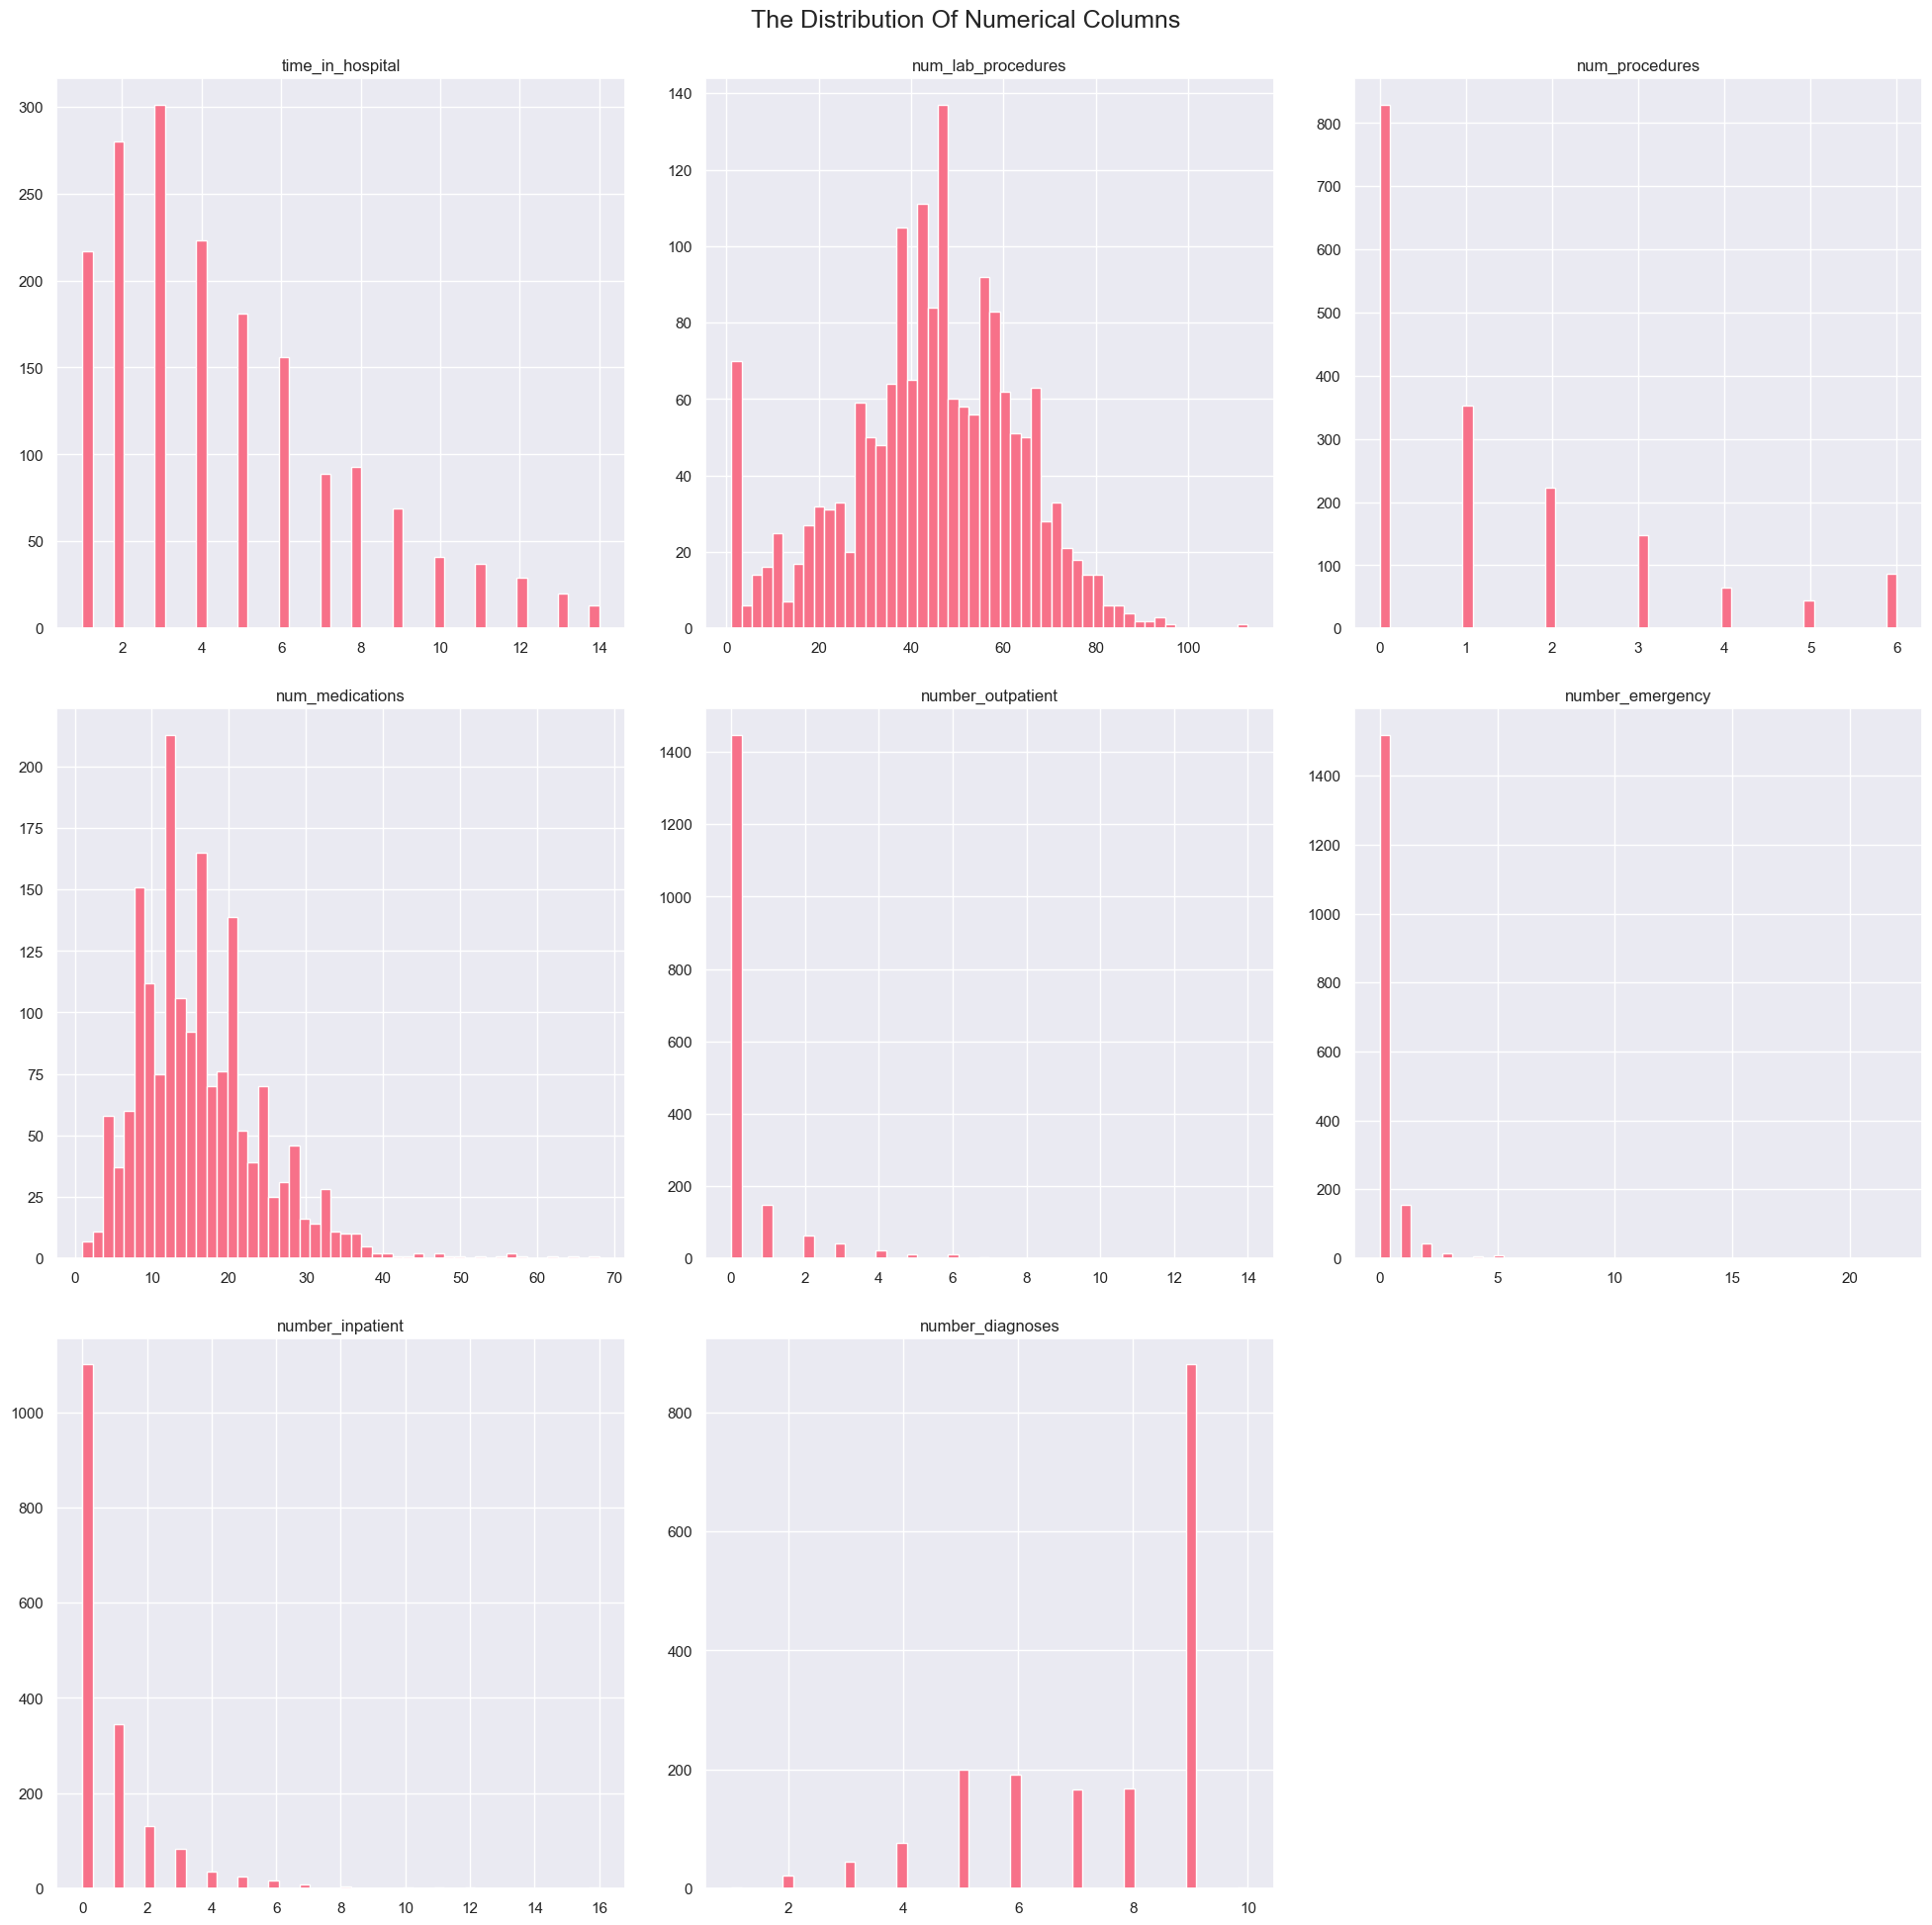

In [10]:
train_data[num_cols].hist(figsize=(20, 20), bins=50)
plt.suptitle('The Distribution Of Numerical Columns', fontsize=18)
plt.tight_layout(pad = 2)

Most of the columns are highly skewed.

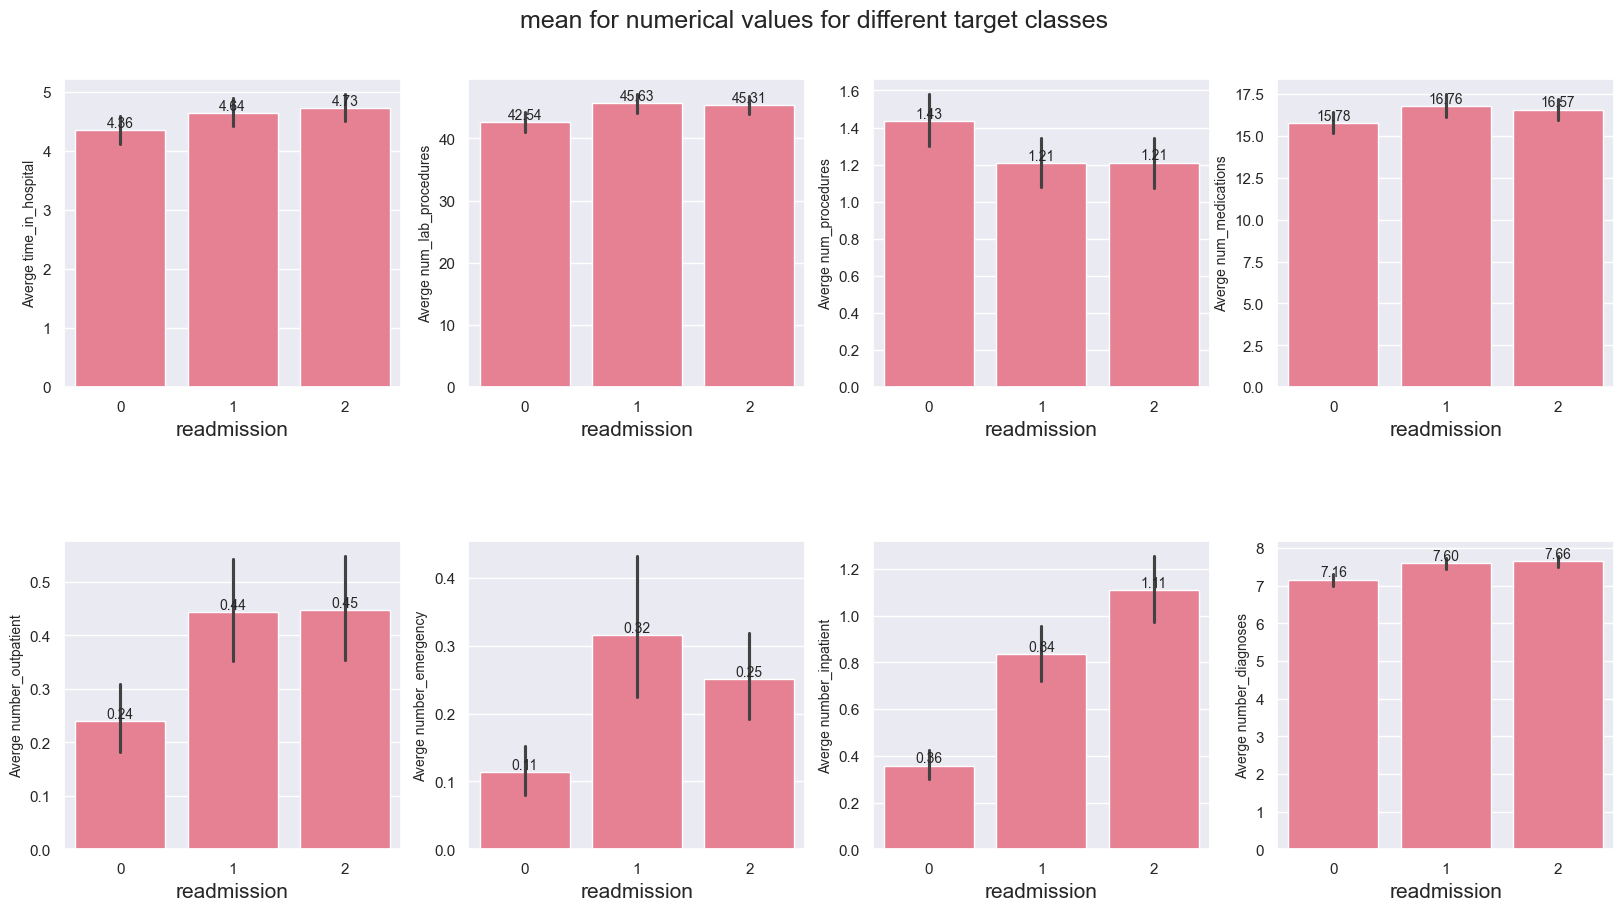

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("mean for numerical values for different target classes",
             fontsize=18,
             y=0.95)

for column, ax in zip(num_cols, axs.ravel()):
    sns.barplot(x=train_data['readmitted'], y=train_data[column], ax=ax)
    ax.set_xlabel("readmission", fontsize=15)
    ax.set_ylabel(f"Averge {column}", fontsize=10)
    for container in ax.containers:
        ax.bar_label(container, fontsize=10, fmt='%.2f')
plt.show()

We can notice that some columns, like number_outpatient, number_emergency and number_inpatient have highly different means for different classes. This means that these columns are highly correlated to the target classes, and they are associated with the highest importance (hopefully).

**Analyze ID Columns**

In [12]:
print(train_data.groupby(['patient_nbr'])['patient_nbr'].count().sort_values(ascending=False))


patient_nbr
94072113     3
14378787     3
333252       2
75169035     2
40816332     2
            ..
32775201     1
32738040     1
32693922     1
32631093     1
186774602    1
Name: patient_nbr, Length: 1720, dtype: int64


The patient number is unique for every patient and every patient can have multiple encounters. We will use them to extract two new important features:

Total number of visits.
Visit number.

**Analyze Diagnoses Columns**

In [13]:
train_data[diag_cols[0]].value_counts()


diag_1
428    118
414     97
786     71
486     65
410     65
      ... 
135      1
424      1
380      1
351      1
225      1
Name: count, Length: 246, dtype: int64

# Data Preprocessing

In [14]:
X_num = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses'
]

X_cat = [
    'race', 'gender', 'age', 'max_glu_serum', 'A1Cresult', 'metformin',
    'repaglinide', 'nateglinide', 'glimepiride', 'glipizide', 'glyburide',
    'pioglitazone', 'rosiglitazone', 'insulin', 'change', 'diabetesMed',
    'payer_code'
]

X_diag = ['diag_1', 'diag_2', 'diag_3']

X_id = ['encounter_id', "patient_nbr"]

We will apply the following for each type:

1- Categorical columns => Mode Imputer =>KeepTopValuesTransformer => Target encoder

2- Numerical columns => Median Imputer => MinMax scaler

3- Diagnosis columns => Diagnosis transformer => Mode Imputer => Target encoder


In [15]:
# Map ICD-9 codes to categories (custom grouping)
icd9_categories = {
    "Infectious and parasitic diseases": range(1, 140),
    "Neoplasms": range(140, 240),
    "Endocrine, nutritional and metabolic diseases": range(240, 280),
    "Diseases of the blood and blood-forming organs": range(280, 290),
    "Mental disorders": range(290, 320),
    "Diseases of the nervous system and sense organs": range(320, 390),
    "Diseases of the circulatory system": range(390, 460),
    "Diseases of the respiratory system": range(460, 520),
    "Diseases of the digestive system": range(520, 580),
    "Diseases of the genitourinary system": range(580, 630),
    "Complications of pregnancy, childbirth, and the puerperium": range(630, 680),
    "Diseases of the skin and subcutaneous tissue": range(680, 710),
    "Diseases of the musculoskeletal system and connective tissue": range(710, 740),
    "Congenital anomalies": range(740, 760),
    "Certain conditions originating in the perinatal period": range(760, 780),
    "Symptoms, signs, and ill-defined conditions": range(780, 800),
    "Injury and poisoning": range(800, 1000),
}

# Function to map ICD-9 code to category
def map_icd9_to_category(code):
    try:
        numeric_code = int(str(code).strip()[:3])  # Strip whitespace and convert
        for category, code_range in icd9_categories.items():
            if numeric_code in code_range:
                return category
        return "Unknown"
    except ValueError:
        if str(code).startswith('V'):
            return "Supplementary classification (V codes)"
        elif str(code).startswith('E'):
            return "External causes of injury (E codes)"
        else:
            return "Unknown"
        

for col in X_diag:
    X_train[f'{col}'] = X_train[col].apply(map_icd9_to_category)

Apply processing

In [16]:
cat_pipeline = Pipeline([("mode imputer"  , SimpleImputer(strategy="most_frequent")),
                         ("target encoder", TargetEncoder())])

num_pipeline = Pipeline([('median imputer', SimpleImputer(strategy="median")),
                         ("MinMax scaler" , MinMaxScaler())])

diag_pipeline = Pipeline([("mode imputer", SimpleImputer(strategy="most_frequent")),
                          ("target encoder", TargetEncoder())])

full_pipeline = ColumnTransformer(transformers=[("num", num_pipeline, X_num),
                                                ("cat", cat_pipeline, X_cat),
                                                ("diag", diag_pipeline, X_diag)]) # remove other columns

In [17]:
X_train.shape

(1749, 49)

In [18]:
if y_train.dtype == 'object':
    y_train = y_train.astype('category').cat.codes
    
    
# This is just for testing, we don't want to transform it yet
X_train_prepared = full_pipeline.fit_transform(X_train,y_train)

    
print("Shape of X_train:", X_train_prepared.shape)

Shape of X_train: (1749, 28)


# Hierarchical clustering

For Hierarchical clustering we are using Chi-Square Test for feature selection. Thus, we need to transform the numerical features into categorical.

In [19]:
X_train[X_num].describe()

time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
count       1749.000000         1749.000000     1749.000000      1749.000000   
mean           4.578616           44.495140        1.284162        16.369354   
std            2.994316           18.914042        1.686833         8.114928   
min            1.000000            1.000000        0.000000         1.000000   
25%            2.000000           34.000000        0.000000        11.000000   
50%            4.000000           45.000000        1.000000        15.000000   
75%            6.000000           58.000000        2.000000        21.000000   
max           14.000000          113.000000        6.000000        68.000000   

       number_outpatient  number_emergency  number_inpatient  number_diagnoses  
count        1749.000000       1749.000000       1749.000000       1749.000000  
mean            0.377358          0.226415          0.767296          7.472842  
std             1.100484          0.892487          1.425955          1.890897  
min             0.000000          0.000000          0.000000          1.000000  
25%             0.000000          0.000000          0.000000          6.000000  
50%             0.000000          0.000000          0.000000          9.000000  
75%             0.000000          0.000000          1.000000          9.000000  
max            14.000000         22.000000         16.000000         10.000000

6 bins created for each numerical feature, so that they can be considered as categorical.

In [20]:
X_train_copy = X_train.copy()

# Binning numericals
for col in X_num:
    bins = np.linspace(X_train_copy[col].min(), X_train_copy[col].max(), num=6)  
    X_train_copy[col] = np.digitize(X_train_copy[col], bins, right=False)

In [21]:
X_train_copy[X_num].describe()

time_in_hospital  num_lab_procedures  num_procedures  num_medications  \
count       1749.000000         1749.000000     1749.000000      1749.000000   
mean           1.929674            2.446541        1.758148         1.630646   
std            1.123992            0.849772        1.369974         0.693793   
min            1.000000            1.000000        1.000000         1.000000   
25%            1.000000            2.000000        1.000000         1.000000   
50%            2.000000            2.000000        1.000000         2.000000   
75%            2.000000            3.000000        2.000000         2.000000   
max            6.000000            6.000000        6.000000         6.000000   

       number_outpatient  number_emergency  number_inpatient  number_diagnoses  
count        1749.000000       1749.000000       1749.000000       1749.000000  
mean            1.064037          1.010292          1.064037          4.106346  
std             0.307075          0.150922          0.307075          1.051919  
min             1.000000          1.000000          1.000000          1.000000  
25%             1.000000          1.000000          1.000000          3.000000  
50%             1.000000          1.000000          1.000000          5.000000  
75%             1.000000          1.000000          1.000000          5.000000  
max             6.000000          6.000000          6.000000          6.000000

Also, create the dataset we are going to use for Chi Square. It is the same as the initial train dataset, but with the binned numerical features.

In [22]:
data_for_chi2 = pd.concat([X_train_copy,y_train], axis=1)

columns_used_chi2 = X_num + X_cat + X_diag

columns_used_chi2

['time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 'race',
 'gender',
 'age',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'glimepiride',
 'glipizide',
 'glyburide',
 'pioglitazone',
 'rosiglitazone',
 'insulin',
 'change',
 'diabetesMed',
 'payer_code',
 'diag_1',
 'diag_2',
 'diag_3']

Perform Chi Square Test with p-value=5% and observe which features are significant to our Y feature (readmitted).

In [23]:
p_value_threshold = 0.05

columns_to_drop = []

# Perform chi-square test for each feature
for col in columns_used_chi2:
    contingency_table = pd.crosstab(data_for_chi2[col], data_for_chi2['readmitted']) 
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"{col}: p-value = {p}")
    if p > p_value_threshold:
        print(f"Dropping {col} (p-value = {p}, weak dependency)")
        columns_to_drop.append(col)

cleaned = data_for_chi2.drop(columns=columns_to_drop)

selected_features = [col for col in columns_used_chi2 if col not in columns_to_drop]

print(f"Remaining columns: {selected_features}")

time_in_hospital: p-value = 0.06832683807387996
Dropping time_in_hospital (p-value = 0.06832683807387996, weak dependency)
num_lab_procedures: p-value = 0.12811452979772256
Dropping num_lab_procedures (p-value = 0.12811452979772256, weak dependency)
num_procedures: p-value = 0.1565453826955596
Dropping num_procedures (p-value = 0.1565453826955596, weak dependency)
num_medications: p-value = 0.12253114516129433
Dropping num_medications (p-value = 0.12253114516129433, weak dependency)
number_outpatient: p-value = 0.3070650053941554
Dropping number_outpatient (p-value = 0.3070650053941554, weak dependency)
number_emergency: p-value = 0.3263053149860538
Dropping number_emergency (p-value = 0.3263053149860538, weak dependency)
number_inpatient: p-value = 3.21573112102277e-07
number_diagnoses: p-value = 0.0014207559932153543
race: p-value = 0.2519964671988127
Dropping race (p-value = 0.2519964671988127, weak dependency)
gender: p-value = 0.8762490285188873
Dropping gender (p-value = 0.876249

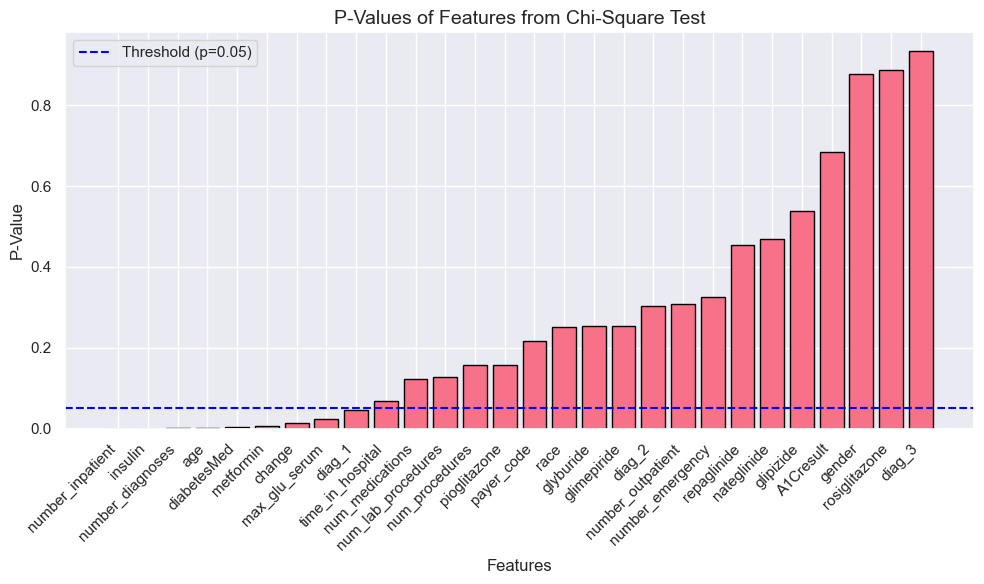

In [24]:
p_values = []

for col in columns_used_chi2:
    contingency_table = pd.crosstab(data_for_chi2[col], data_for_chi2['readmitted']) 
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    p_values.append((col, p)) 

p_values_df = pd.DataFrame(p_values, columns=['Feature', 'p-value'])

p_values_df = p_values_df.sort_values(by='p-value')

plt.figure(figsize=(10, 6))
plt.bar(p_values_df['Feature'], p_values_df['p-value'],  edgecolor='black')
plt.axhline(y=0.05, color='blue', linestyle='--', label='Threshold (p=0.05)')
plt.xticks(rotation=45, ha='right')
plt.title('P-Values of Features from Chi-Square Test', fontsize=14)
plt.xlabel('Features', fontsize=12)
plt.ylabel('P-Value', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

Only the selected features will be used for the clustering. Thus, the data is prepared for that.

In [25]:
# Function to get the transformed names of the features
def get_transformed_feature_names(column_transformer, original_feature_names):
    transformed_names = []
    
    for name, transformer, columns in column_transformer.transformers_:
        if transformer == 'drop':
            continue 
        if transformer == 'passthrough':
            transformed_names.extend(columns)
        elif isinstance(transformer, OneHotEncoder):
            for feature in columns:
                transformed_names.extend([f"{feature}_{i}" for i in range(len(transformer.categories_[0]))])
        elif isinstance(transformer, TargetEncoder):
            transformed_names.extend(columns)
        else:
            transformed_names.extend(columns)

    return transformed_names

transformed_feature_names = get_transformed_feature_names(full_pipeline, X_train.columns.tolist())

selected_feature_indices = [transformed_feature_names.index(f) for f in selected_features]

# Transform the data using full pipeline
X_transformed = full_pipeline.fit_transform(X_train, y_train)

# and now keep oly the values of the selected features
X_selected = X_transformed[:, selected_feature_indices]

In [26]:
print(X_selected[:5, :])  
print(X_selected.shape) 

[[0.         0.22222222 0.92631579 1.17483033 1.02410468 0.90091265
  0.94816415 1.02741703 0.86154077]
 [0.0625     0.44444444 1.04504505 0.99529965 0.87037037 1.00750469
  1.05832321 1.02741703 0.7982087 ]
 [0.         0.55555556 0.92631579 0.99529965 1.02410468 0.90091265
  0.94816415 0.8953168  1.04504002]
 [0.         0.88888889 1.04504505 0.99529965 1.02410468 0.90091265
  0.94816415 0.8953168  1.04504002]
 [0.0625     0.88888889 1.06989247 0.99529965 1.02410468 0.90091265
  0.94816415 1.02741703 0.86154077]]
(1749, 9)


Start with a random number of clusters and check the dedrogram.

In [27]:
distance_matrix = gower.gower_matrix(X_selected)

# For hierarchical clustering we will use average linkage as it is suited for mixed data
agg_clustering = AgglomerativeClustering(
    n_clusters=50,  
    metric='precomputed',       
    linkage='average'
)
agg_labels = agg_clustering.fit_predict(distance_matrix)

agg_silhouette = silhouette_score(distance_matrix, agg_labels, metric="precomputed")
print(f"Agglomerative Silhouette Score: {agg_silhouette}")

agg_db = davies_bouldin_score(X_selected, agg_labels)
print(f"Agglomerative Davies-Bouldin Index: {agg_db}")

Agglomerative Silhouette Score: 0.29284557700157166
Agglomerative Davies-Bouldin Index: 1.9493125525099178


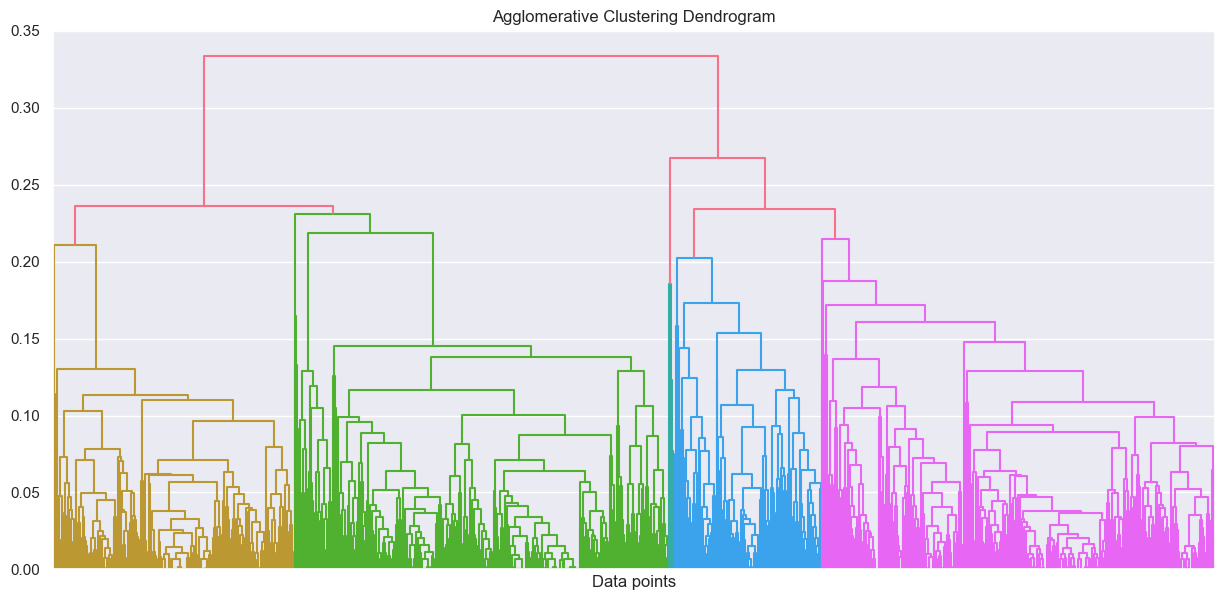

In [28]:
condensed_distance_matrix = squareform(distance_matrix)

linkage_matrix = linkage(condensed_distance_matrix, method='average')

plt.figure(figsize=(15, 7))
dendrogram(linkage_matrix)
plt.title("Agglomerative Clustering Dendrogram")
plt.xlabel("Data points")
plt.xticks([])
plt.show()

Use Silhouette score and Davies-Bouldin Index to determine the optimal number of clusters.

Optimal Clusters (Silhouette Score): 7
Optimal Clusters (Davies-Bouldin Index): 37
Optimal Clusters (Combined Score): 18


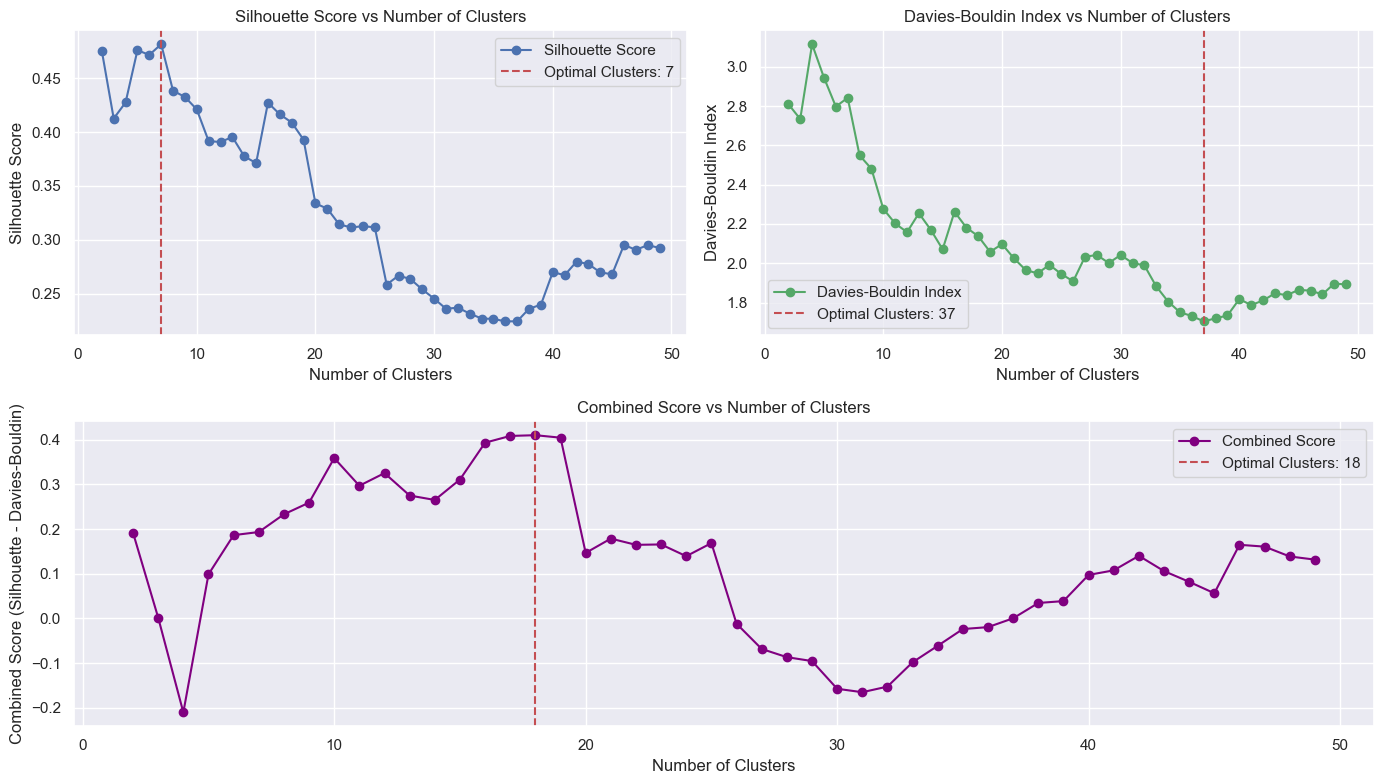

In [29]:
# We will go up to 50 clusters for that
cluster_range = range(2, 50)  
silhouette_scores = []
db_scores = []

# Compute Silhouette score and Davies-Bouldin Index for each number of clusters
for n_clusters in cluster_range:
    agg_clustering = AgglomerativeClustering(
        n_clusters=n_clusters,
        metric='precomputed',
        linkage='average'
    )
    agg_labels = agg_clustering.fit_predict(distance_matrix)

    silhouette_avg = silhouette_score(distance_matrix, agg_labels, metric="precomputed")
    silhouette_scores.append(silhouette_avg)

    db_score = davies_bouldin_score(X_selected, agg_labels)
    db_scores.append(db_score)

scaler = MinMaxScaler()
silhouette_scaled = scaler.fit_transform(np.array(silhouette_scores).reshape(-1, 1)).flatten()
db_scaled = scaler.fit_transform(np.array(db_scores).reshape(-1, 1)).flatten()

combined_score = silhouette_scaled - db_scaled
optimal_clusters_combined = cluster_range[np.argmax(combined_score)]

optimal_clusters_silhouette = cluster_range[np.argmax(silhouette_scores)]
optimal_clusters_db = cluster_range[np.argmin(db_scores)]

print(f"Optimal Clusters (Silhouette Score): {optimal_clusters_silhouette}")
print(f"Optimal Clusters (Davies-Bouldin Index): {optimal_clusters_db}")
print(f"Optimal Clusters (Combined Score): {optimal_clusters_combined}")

plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.plot(cluster_range, silhouette_scores, marker='o', label='Silhouette Score', color='b')
plt.axvline(optimal_clusters_silhouette, color='r', linestyle='--', label=f"Optimal Clusters: {optimal_clusters_silhouette}")
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(cluster_range, db_scores, marker='o', label='Davies-Bouldin Index', color='g')
plt.axvline(optimal_clusters_db, color='r', linestyle='--', label=f"Optimal Clusters: {optimal_clusters_db}")
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index vs Number of Clusters')
plt.legend()

# Combined Score plot
plt.subplot(2, 1, 2)
plt.plot(cluster_range, combined_score, marker='o', label='Combined Score', color='purple')
plt.axvline(optimal_clusters_combined, color='r', linestyle='--', label=f"Optimal Clusters: {optimal_clusters_combined}")
plt.xlabel('Number of Clusters')
plt.ylabel('Combined Score (Silhouette - Davies-Bouldin)')
plt.title('Combined Score vs Number of Clusters')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [30]:
def calculate_dunn_index(distance_matrix, labels):
    unique_labels = np.unique(labels)
    intra_cluster_dists = []
    inter_cluster_dists = []

    for label in unique_labels:
        cluster_points = np.where(labels == label)[0]
        if len(cluster_points) > 1:
            intra_distances = distance_matrix[np.ix_(cluster_points, cluster_points)]
            intra_cluster_dists.append(np.max(intra_distances))
        else:
            intra_cluster_dists.append(0)

    for i, label1 in enumerate(unique_labels):
        for j, label2 in enumerate(unique_labels):
            if i < j:
                cluster_points_1 = np.where(labels == label1)[0]
                cluster_points_2 = np.where(labels == label2)[0]
                inter_distances = distance_matrix[np.ix_(cluster_points_1, cluster_points_2)]
                inter_cluster_dists.append(np.min(inter_distances))

    if intra_cluster_dists and inter_cluster_dists:
        dunn_index = min(inter_cluster_dists) / max(intra_cluster_dists)
    else:
        dunn_index = 0
    return dunn_index

clusters_to_analyze = [18]

results = {}

for n_clusters in clusters_to_analyze:
    agg_clustering = AgglomerativeClustering(
        n_clusters=n_clusters,
        metric='precomputed',
        linkage='average'
    )
    agg_labels = agg_clustering.fit_predict(distance_matrix)

    silhouette_avg = silhouette_score(distance_matrix, agg_labels, metric="precomputed")
    db_score = davies_bouldin_score(X_selected, agg_labels)
    dunn_index = calculate_dunn_index(distance_matrix, agg_labels)

    results[n_clusters] = {
        'labels': agg_labels,
        'silhouette_score': silhouette_avg,
        'davies_bouldin_score': db_score,
        'dunn_index': dunn_index
    }

for n_clusters, metrics in results.items():
    print(f"Results for {n_clusters} Clusters:")
    print(f"  Silhouette Score: {metrics['silhouette_score']:.4f}")
    print(f"  Davies-Bouldin Index: {metrics['davies_bouldin_score']:.4f}")
    print(f"  Dunn Index: {metrics['dunn_index']:.4f}")

Results for 18 Clusters:
  Silhouette Score: 0.4088
  Davies-Bouldin Index: 2.1376
  Dunn Index: 0.1146


Clustering method selection based on a combined score of the Silhouette Score, Davies-Bouldin Index	and Dunn Index.

In [31]:
methods = ["Hierarchical Clustering", "K-prototypes", "K-means PCA selected features", "K-means PCA ICD-9"]
silhouette = [0.4088, -0.0333, 0.6295, 0.2679]
davies_bouldin = [2.1376, 29.5218, 0.4392, 1.3397]
dunn = [0.1146, 0.0022, 0.0111, 0.0085]

silhouette_min, silhouette_max = min(silhouette), max(silhouette)
davies_bouldin_min, davies_bouldin_max = min(davies_bouldin), max(davies_bouldin)
dunn_min, dunn_max = min(dunn), max(dunn)

normalized_silhouette = [(s - silhouette_min) / (silhouette_max - silhouette_min) for s in silhouette]
normalized_davies_bouldin = [(davies_bouldin_max - db) / (davies_bouldin_max - davies_bouldin_min) for db in davies_bouldin]
normalized_dunn = [(d - dunn_min) / (dunn_max - dunn_min) for d in dunn]

composite_scores = [(ns + ndb + nd) / 3 for ns, ndb, nd in zip(normalized_silhouette, normalized_davies_bouldin, normalized_dunn)]

results_df = pd.DataFrame({
    "Method": methods,
    "Silhouette Score": silhouette,
    "Normalized Silhouette": normalized_silhouette,
    "Davies-Bouldin Index": davies_bouldin,
    "Normalized DBI": normalized_davies_bouldin,
    "Dunn Index": dunn,
    "Normalized Dunn": normalized_dunn,
    "Composite Score": composite_scores
})

results_df.sort_values("Composite Score", ascending=False, inplace=True)

results_df

Method  Silhouette Score  Normalized Silhouette  \
0        Hierarchical Clustering            0.4088               0.667019   
2  K-means PCA selected features            0.6295               1.000000   
3              K-means PCA ICD-9            0.2679               0.454436   
1                   K-prototypes           -0.0333               0.000000   

   Davies-Bouldin Index  Normalized DBI  Dunn Index  Normalized Dunn  \
0                2.1376        0.941601      0.1146         1.000000   
2                0.4392        1.000000      0.0111         0.079181   
3                1.3397        0.969036      0.0085         0.056050   
1               29.5218        0.000000      0.0022         0.000000   

   Composite Score  
0         0.869540  
2         0.693060  
3         0.493174  
1         0.000000

The distribution of patients in clusters.

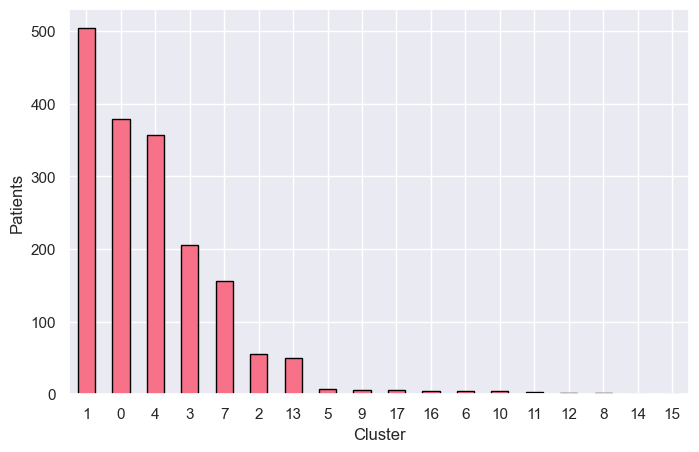

In [32]:
final_data = pd.concat([X_train,y_train], axis=1)
final_data['cluster'] = results[18]['labels']

plt.figure(figsize=(8, 5))
final_data['cluster'].value_counts().plot(kind='bar', edgecolor='black')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Patients', fontsize=12)
plt.xticks(rotation=0)
plt.show()

And readmitted distributions.

In [33]:
print("\nReadmitted Value Counts")
print(final_data.groupby('cluster')['readmitted'].value_counts())


Readmitted Value Counts
cluster  readmitted
0        2             153
         1             134
         0              92
1        1             181
         2             164
         0             160
2        2              23
         1              18
         0              15
3        1              71
         2              69
         0              65
4        0             148
         2             107
         1             102
5        2               5
         0               1
         1               1
6        1               3
         2               1
7        0              66
         1              50
         2              40
8        1               1
         2               1
9        0               2
         1               2
         2               2
10       1               2
         2               2
11       2               2
         0               1
12       0               2
13       0              27
         1              13
         2

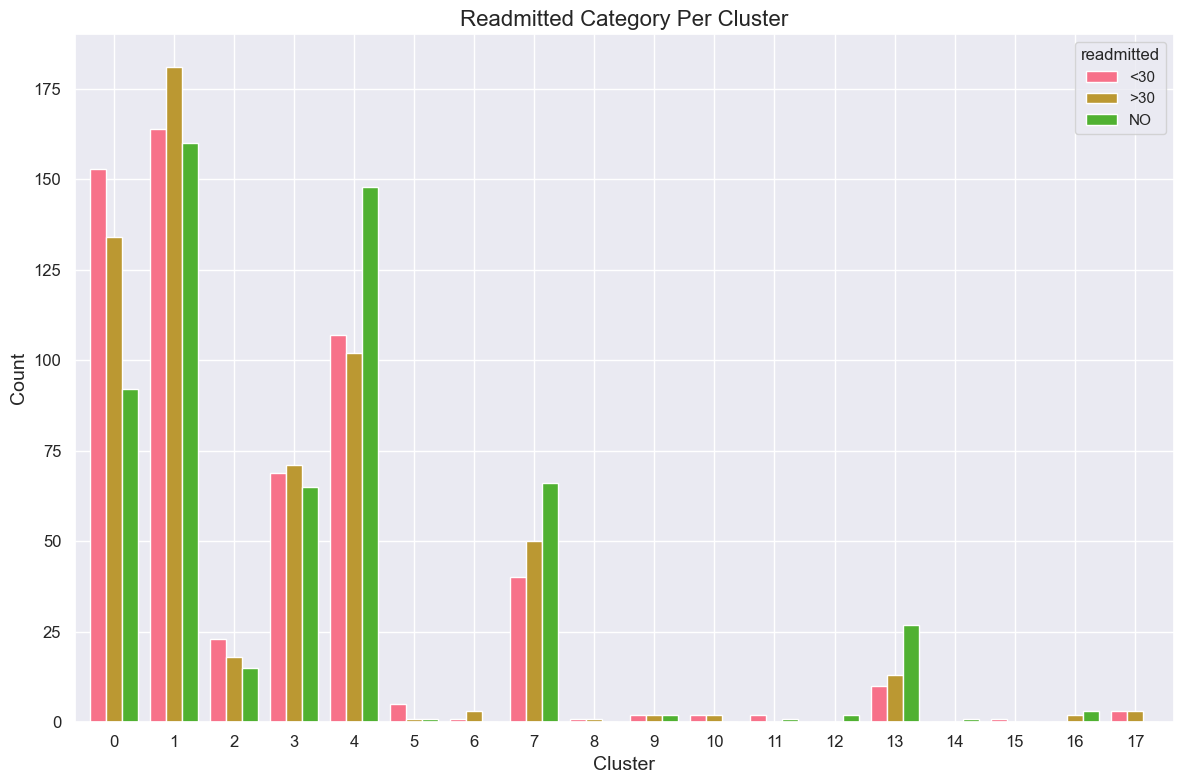

In [34]:
final_data['readmitted'] = final_data['readmitted'].map({0: 'NO', 1: '>30', 2: '<30'})
readmitted_counts = final_data.groupby('cluster')['readmitted'].value_counts().unstack(fill_value=0)

ax = readmitted_counts.plot(kind='bar', stacked=False, figsize=(12, 8), width=0.8)

plt.title('Readmitted Category Per Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

Visualization of categorical, diagnosis and numerical features respectively.

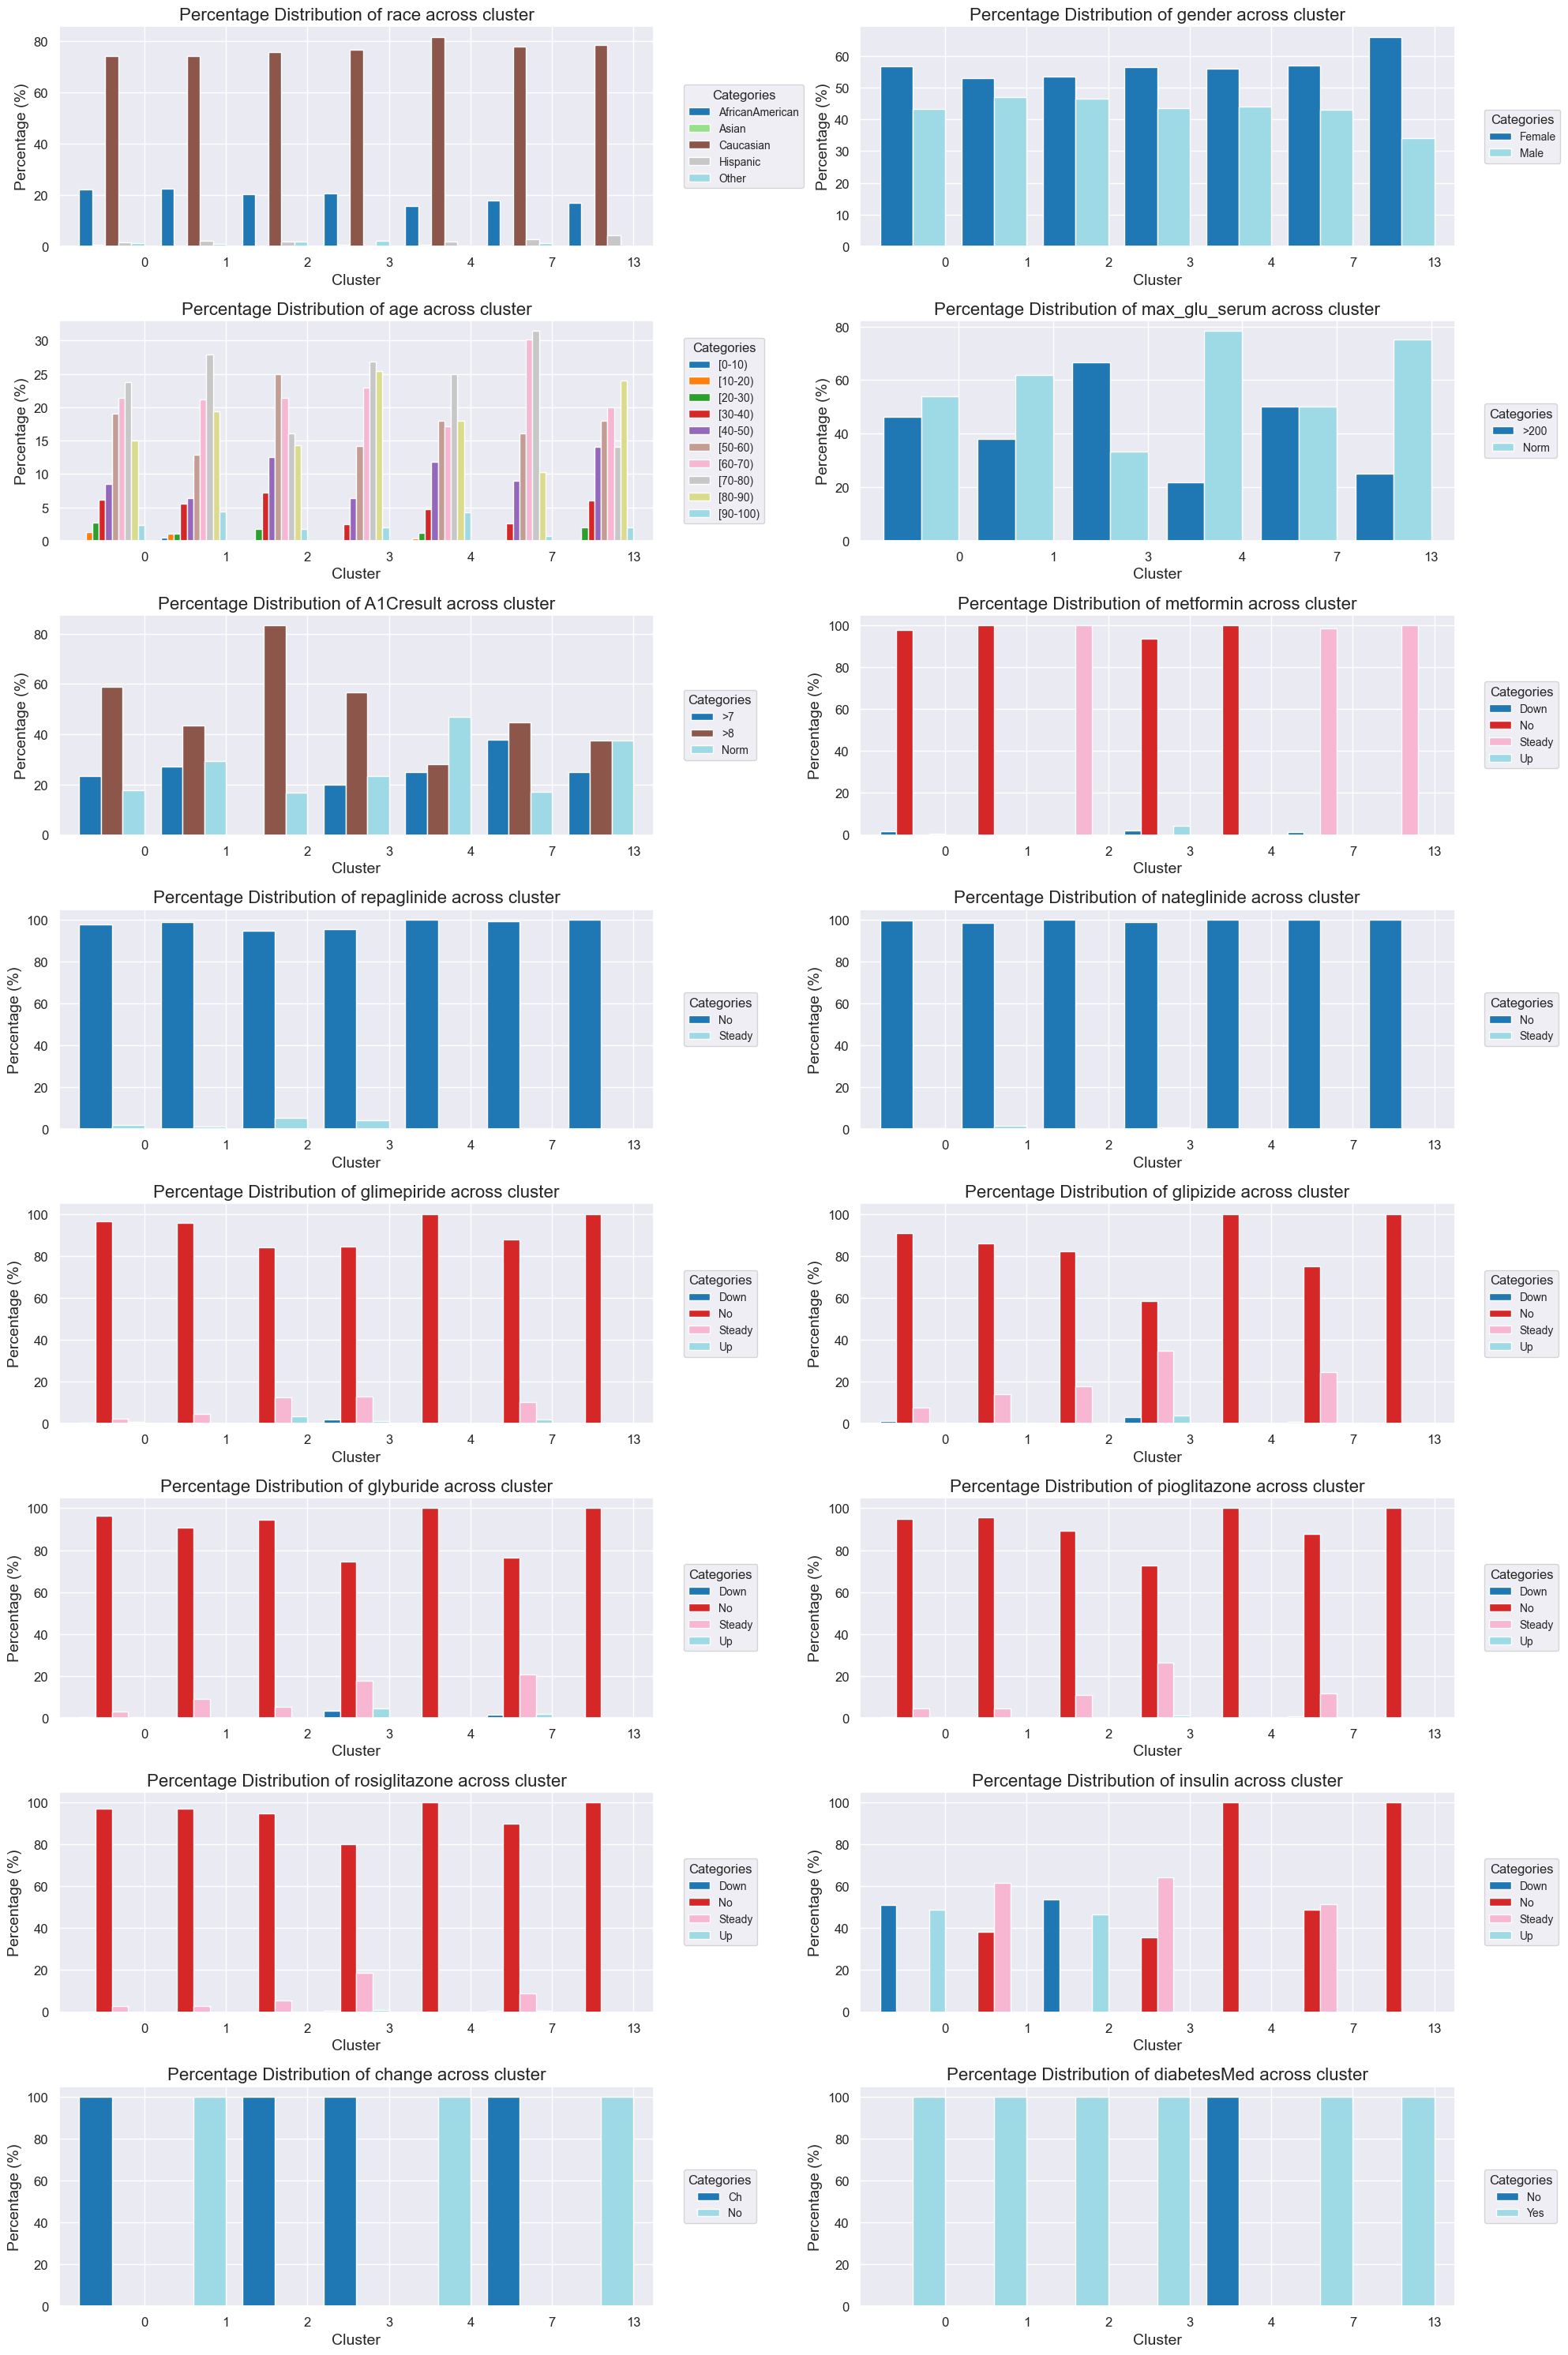

In [35]:
filtered_X_cat = [feature for feature in X_cat if feature != 'payer_code']

def plot_grouped_percentage_distribution_for_cat(df, cat_features, cluster_column, clusters_to_include):
    df_filtered = df[df[cluster_column].isin(clusters_to_include)]
    n_features = len(cat_features)
    n_rows = (n_features + 1) // 2
    fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(20, 30))
    axes = axes.flatten()
    
    for idx, feature in enumerate(cat_features):
        ax = axes[idx]
        
        value_counts = df_filtered.groupby(cluster_column)[feature].value_counts(normalize=True).unstack(fill_value=0) * 100
        value_counts.plot(kind='bar', ax=ax, colormap="tab20", width=0.8, position=1)
        
        ax.set_title(f'Percentage Distribution of {feature} across {cluster_column}', fontsize=16)
        ax.set_xlabel('Cluster', fontsize=14)
        ax.set_ylabel('Percentage (%)', fontsize=14)
        ax.tick_params(axis='x', rotation=0, labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        
        ax.legend(
            title="Categories", 
            bbox_to_anchor=(1.05, 0.5), 
            loc='center left', 
            borderaxespad=0.,
            fontsize=10,
            title_fontsize=12
        )

    for i in range(n_features, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# The clusters with the most patients
clusters_to_include = [0, 1, 2, 3, 4, 7, 13]

plot_grouped_percentage_distribution_for_cat(final_data, filtered_X_cat, 'cluster', clusters_to_include)

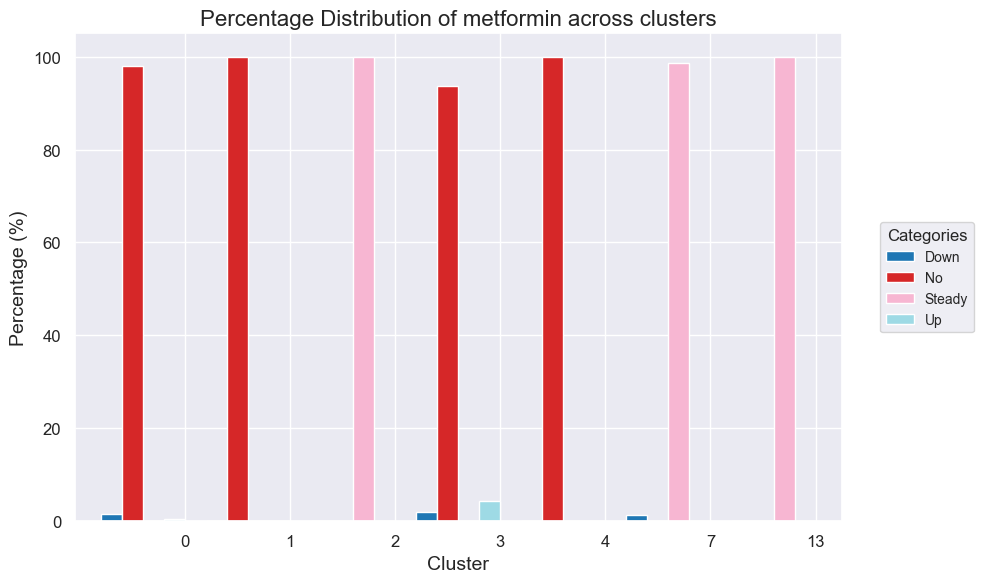

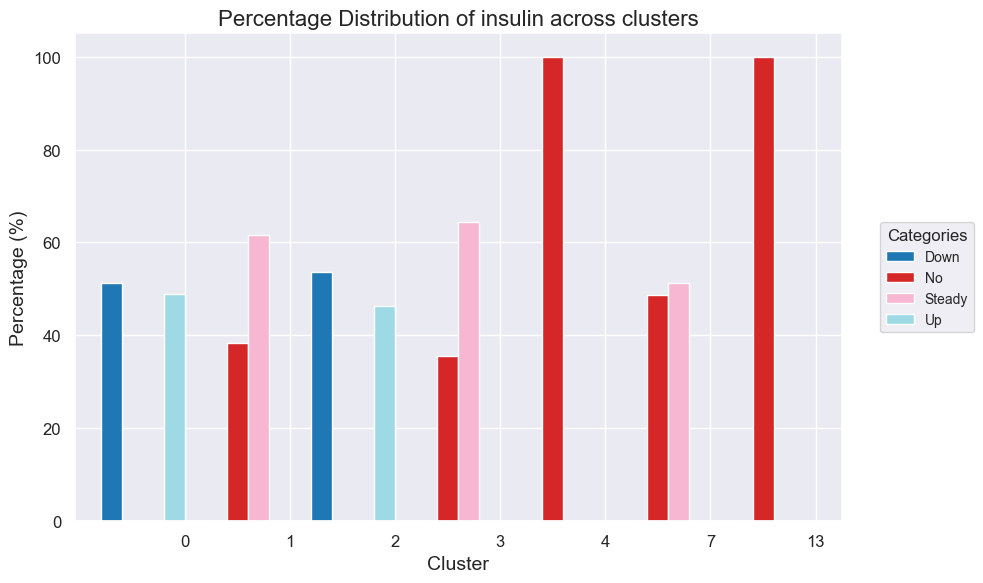

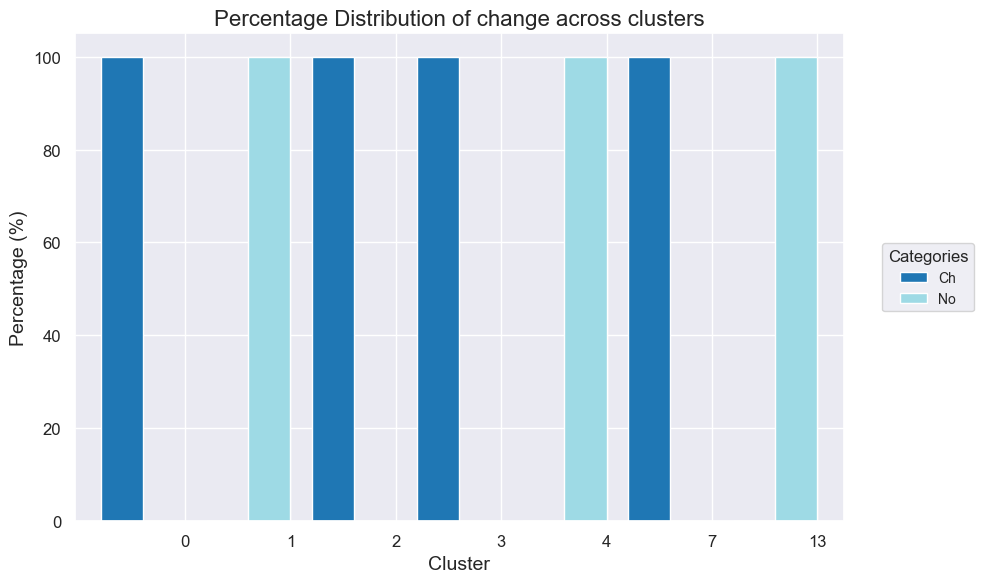

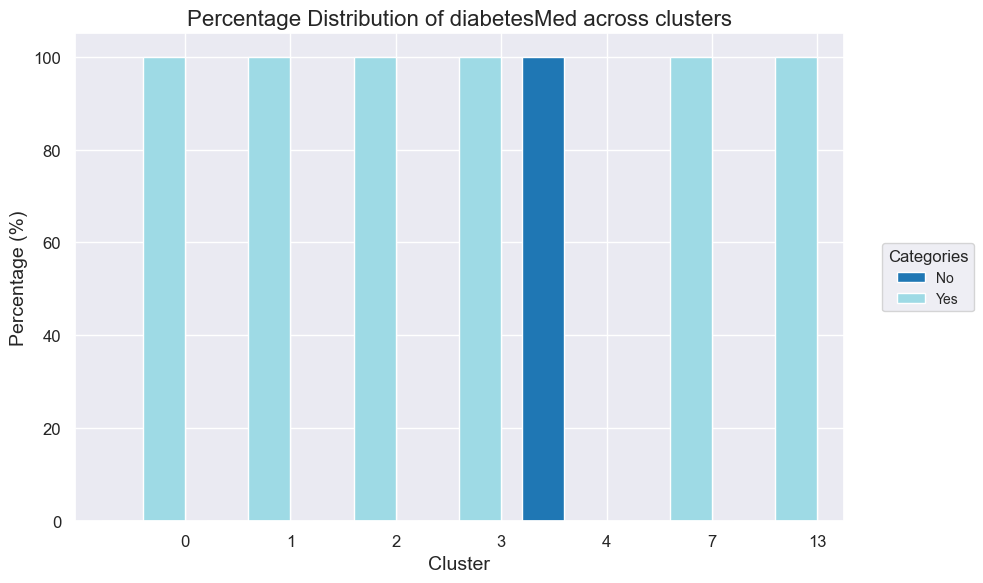

In [36]:
selected_features_new = ['metformin', 'insulin', 'change', 'diabetesMed']

def plot_grouped_distribution(df, cat_features, cluster_column, clusters_to_include):
    df_filtered = df[df[cluster_column].isin(clusters_to_include)]
    
    for idx, feature in enumerate(cat_features):
        fig, ax = plt.subplots(figsize=(10, 6))
        
        value_counts = df_filtered.groupby(cluster_column)[feature].value_counts(normalize=True).unstack(fill_value=0) * 100
        value_counts.plot(kind='bar', ax=ax, colormap="tab20", width=0.8, position=1)
        
        ax.set_title(f'Percentage Distribution of {feature} across {cluster_column}s', fontsize=16)
        ax.set_xlabel('Cluster', fontsize=14)
        ax.set_ylabel('Percentage (%)', fontsize=14)
        ax.tick_params(axis='x', rotation=0, labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        
        ax.legend(
            title="Categories", 
            bbox_to_anchor=(1.05, 0.5), 
            loc='center left', 
            borderaxespad=0.,
            fontsize=10,
            title_fontsize=12
        )
        plt.tight_layout()
        plt.show()

plot_grouped_distribution(final_data, selected_features_new, 'cluster', clusters_to_include)

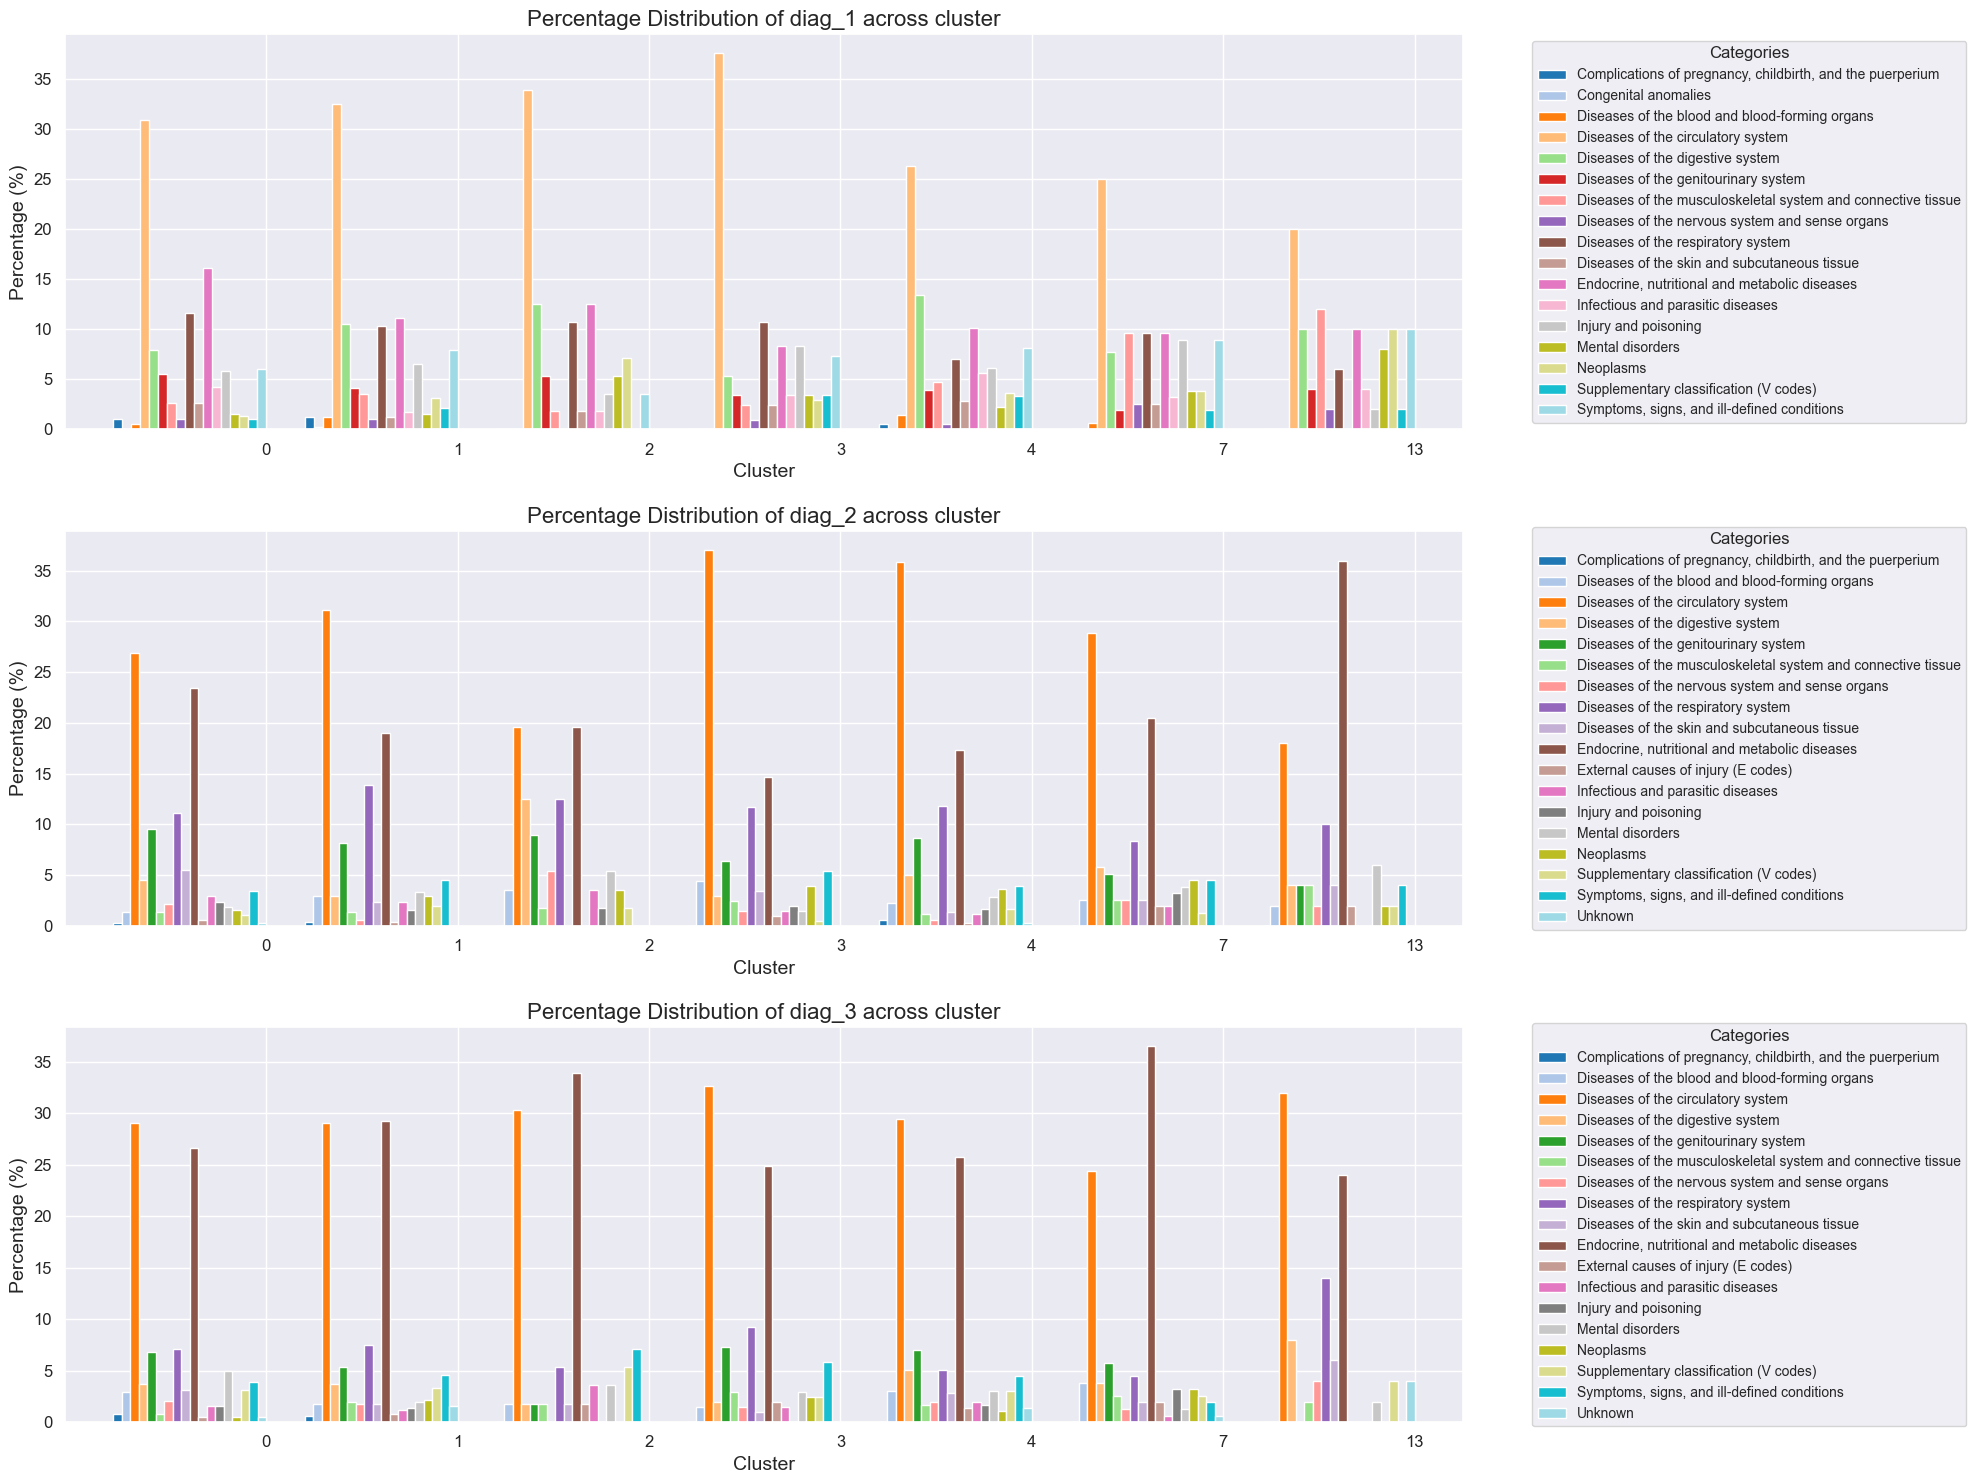

In [37]:
def plot_grouped_percentage_distribution_diag(df, cat_features, cluster_column, clusters_to_include):
    df_filtered = df[df[cluster_column].isin(clusters_to_include)]
    n_features = len(cat_features)
    fig, axes = plt.subplots(nrows=n_features, ncols=1, figsize=(20, 5 * n_features))
    
    if n_features == 1:
        axes = [axes]
    
    for idx, feature in enumerate(cat_features):
        ax = axes[idx]
        
        value_counts = df_filtered.groupby(cluster_column)[feature].value_counts(normalize=True).unstack(fill_value=0) * 100
        value_counts.plot(kind='bar', ax=ax, colormap="tab20", width=0.8, position=1)
        
        ax.set_title(f'Percentage Distribution of {feature} across {cluster_column}', fontsize=16)
        ax.set_xlabel('Cluster', fontsize=14)
        ax.set_ylabel('Percentage (%)', fontsize=14)
        ax.tick_params(axis='x', rotation=0, labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        
        ax.legend(
            title="Categories", 
            bbox_to_anchor=(1.05, 0.5), 
            loc='center left', 
            borderaxespad=0.,
            fontsize=10,
            title_fontsize=12
        )
    plt.tight_layout()
    plt.show()

plot_grouped_percentage_distribution_diag(final_data, X_diag, 'cluster', clusters_to_include)

Means of Features per Cluster:

Feature: time_in_hospital
Cluster 0: 4.910290237467018
Cluster 1: 4.586138613861386
Cluster 2: 5.589285714285714
Cluster 3: 4.819512195121951
Cluster 4: 4.0700280112044815
Cluster 7: 4.25
Cluster 13: 3.96

Feature: num_lab_procedures
Cluster 0: 49.10026385224275
Cluster 1: 44.087128712871284
Cluster 2: 48.910714285714285
Cluster 3: 45.326829268292684
Cluster 4: 41.84033613445378
Cluster 7: 42.17307692307692
Cluster 13: 36.84

Feature: num_procedures
Cluster 0: 1.3087071240105541
Cluster 1: 1.2534653465346535
Cluster 2: 1.5357142857142858
Cluster 3: 1.3414634146341464
Cluster 4: 1.3977591036414565
Cluster 7: 1.0320512820512822
Cluster 13: 1.1

Feature: num_medications
Cluster 0: 19.07915567282322
Cluster 1: 15.302970297029702
Cluster 2: 21.25
Cluster 3: 17.526829268292683
Cluster 4: 13.436974789915967
Cluster 7: 17.46794871794872
Cluster 13: 13.18

Feature: number_outpatient
Cluster 0: 0.45118733509234826
Cluster 1: 0.3584158415841584
Cluster 2: 0.2142857

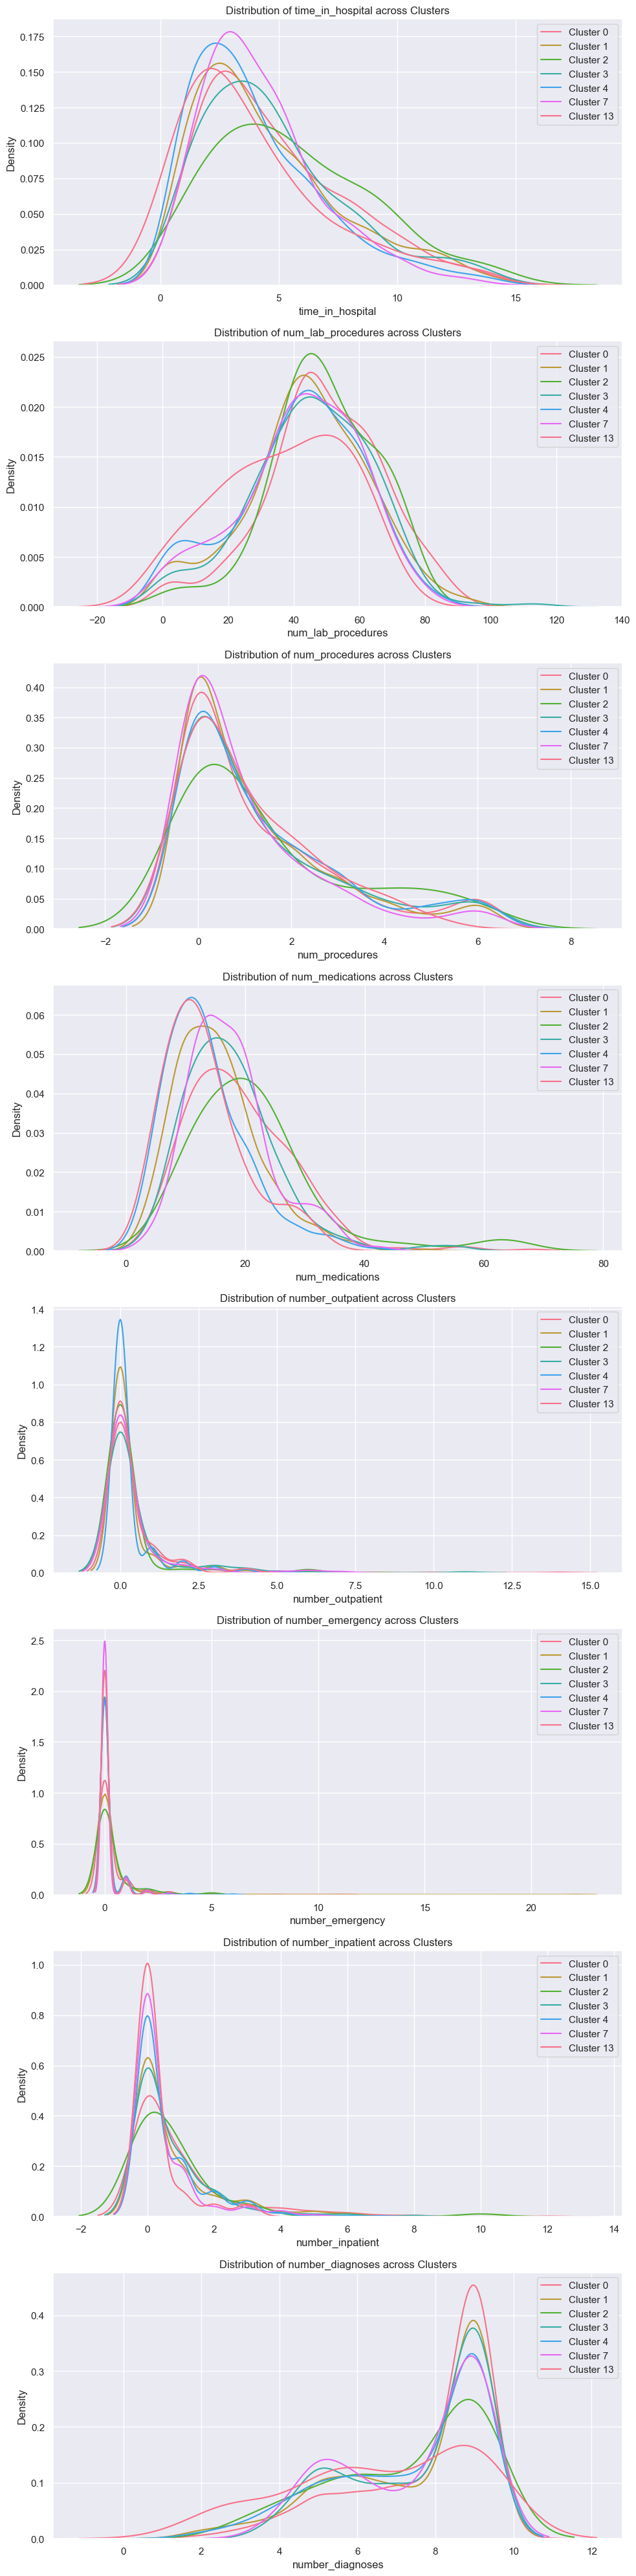

In [38]:
def plot_kde_and_means(df, num_features, cluster_column, selected_clusters):
    df_filtered = df[df[cluster_column].isin(selected_clusters)]
    
    print("Means of Features per Cluster:")
    for feature in num_features:
        print(f"\nFeature: {feature}")
        for cluster in selected_clusters:
            mean_value = df_filtered[df_filtered[cluster_column] == cluster][feature].mean()
            print(f"Cluster {cluster}: {mean_value}")
    
    n_features = len(num_features)
    n_rows = n_features
    n_cols = 1
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 5 * n_rows))
    axes = axes.flatten()

    for idx, feature in enumerate(num_features):
        ax = axes[idx]

        for cluster in selected_clusters:
            sns.kdeplot(df_filtered[df_filtered[cluster_column] == cluster][feature], ax=ax, label=f'Cluster {cluster}', warn_singular=False)
        
        ax.set_title(f'Distribution of {feature} across Clusters')
        ax.set_xlabel(feature)
        ax.set_ylabel('Density')
        ax.legend()

    plt.tight_layout()
    plt.show()

plot_kde_and_means(final_data, X_num, 'cluster', clusters_to_include)

In [39]:
for cluster in clusters_to_include:
    print(f"Value counts grouped by cluster {cluster}")
    
    for feature in selected_features_new:
        print(f"\nValue counts for {feature} grouped by cluster {cluster}:")
        value_counts = final_data[final_data['cluster'].isin([cluster])].groupby('cluster')[feature].value_counts(normalize=False)
        
        print(f"Cluster {cluster}:")
        print(value_counts.droplevel(0))

Value counts grouped by cluster 0

Value counts for metformin grouped by cluster 0:
Cluster 0:
metformin
No      371
Down      6
Up        2
Name: count, dtype: int64

Value counts for insulin grouped by cluster 0:
Cluster 0:
insulin
Down    194
Up      185
Name: count, dtype: int64

Value counts for change grouped by cluster 0:
Cluster 0:
change
Ch    379
Name: count, dtype: int64

Value counts for diabetesMed grouped by cluster 0:
Cluster 0:
diabetesMed
Yes    379
Name: count, dtype: int64
Value counts grouped by cluster 1

Value counts for metformin grouped by cluster 1:
Cluster 1:
metformin
No    505
Name: count, dtype: int64

Value counts for insulin grouped by cluster 1:
Cluster 1:
insulin
Steady    311
No        194
Name: count, dtype: int64

Value counts for change grouped by cluster 1:
Cluster 1:
change
No    505
Name: count, dtype: int64

Value counts for diabetesMed grouped by cluster 1:
Cluster 1:
diabetesMed
Yes    505
Name: count, dtype: int64
Value counts grouped by clus

# K-MEANS AND K-PROTOTYPES

In [40]:
def dunn_index(X, labels):
    """
    Compute the Dunn Index for clustering.
    
    Parameters:
    - X: numpy array or DataFrame with the dataset
    - labels: array-like with cluster labels
    
    Returns:
    - Dunn Index value
    """
    unique_labels = np.unique(labels)
    cluster_distances = []
    cluster_diameters = []

    # Compute inter-cluster distances
    for i, cluster_i in enumerate(unique_labels):
        cluster_i_points = X[labels == cluster_i]
        for j, cluster_j in enumerate(unique_labels):
            if j > i:  # Only compute for distinct clusters
                cluster_j_points = X[labels == cluster_j]
                dist = np.min(cdist(cluster_i_points, cluster_j_points))
                cluster_distances.append(dist)

    # Compute intra-cluster diameters
    for cluster in unique_labels:
        cluster_points = X[labels == cluster]
        if len(cluster_points) > 1:
            diameter = np.max(cdist(cluster_points, cluster_points))
        else:
            diameter = 0  # For single-point clusters, diameter is 0
        cluster_diameters.append(diameter)

    min_intercluster_distance = np.min(cluster_distances)
    max_intracluster_diameter = np.max(cluster_diameters)

    dunn_index_value = min_intercluster_distance / max_intracluster_diameter if max_intracluster_diameter > 0 else np.inf
    return dunn_index_value

Silhouette Score: 0.2678898010343631
Davies-Bouldin Score: 1.3396813693368206
readmitted         0         1         2
cluster                                 
0           0.236311  0.360231  0.403458
1           0.418386  0.294559  0.287054
2           0.319908  0.346375  0.333717


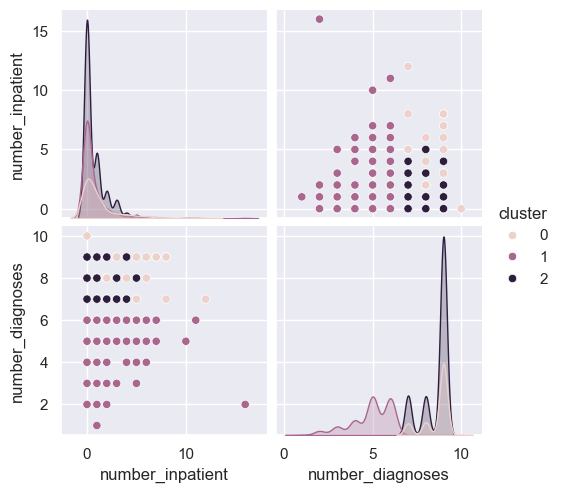

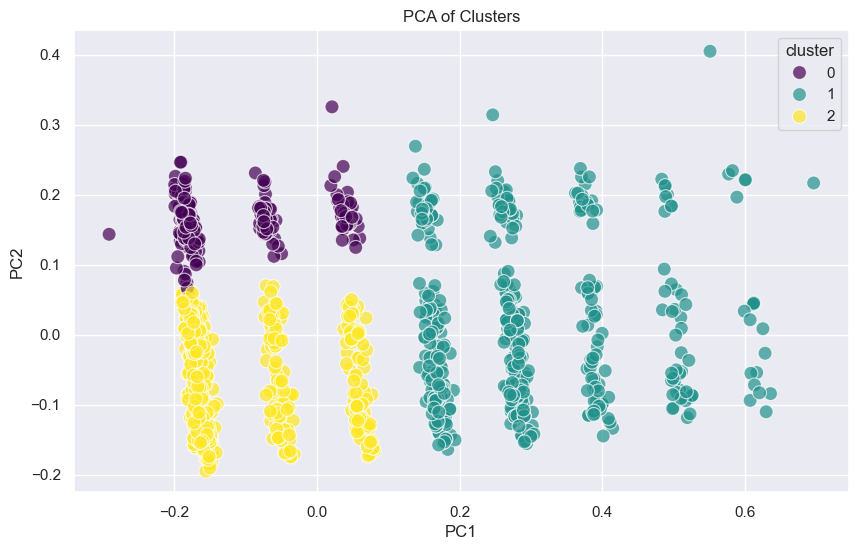

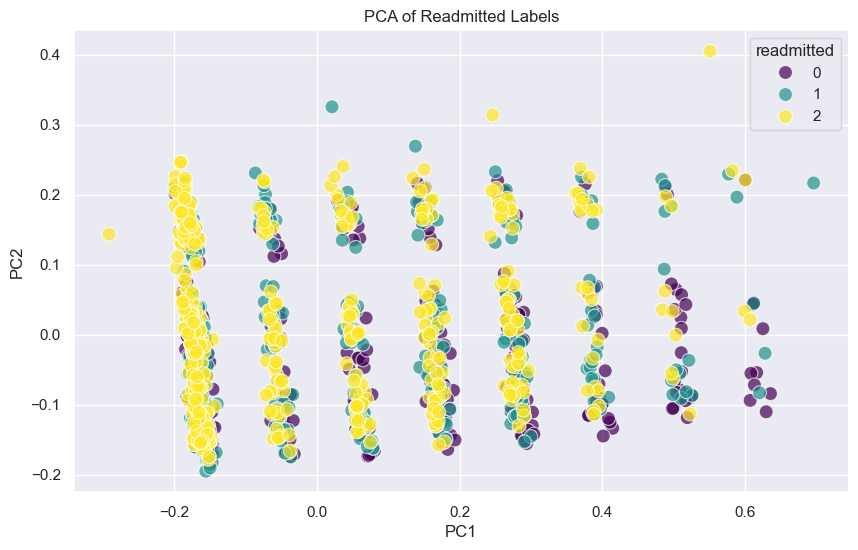

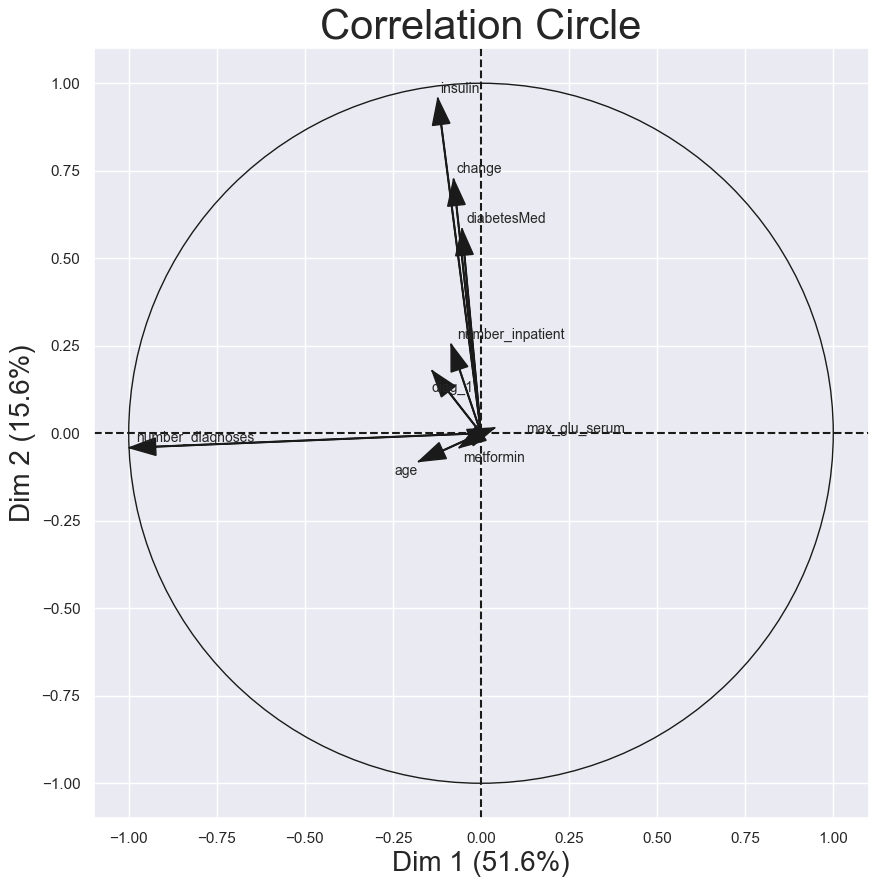

                     Dim 1     Dim 2
number_inpatient -0.084945  0.253910
number_diagnoses -0.998563 -0.041441
age              -0.176832 -0.080687
max_glu_serum     0.038454  0.015268
metformin        -0.061652 -0.040930
insulin          -0.122539  0.956887
change           -0.077749  0.725744
diabetesMed      -0.053912  0.583659
diag_1           -0.138742  0.178377


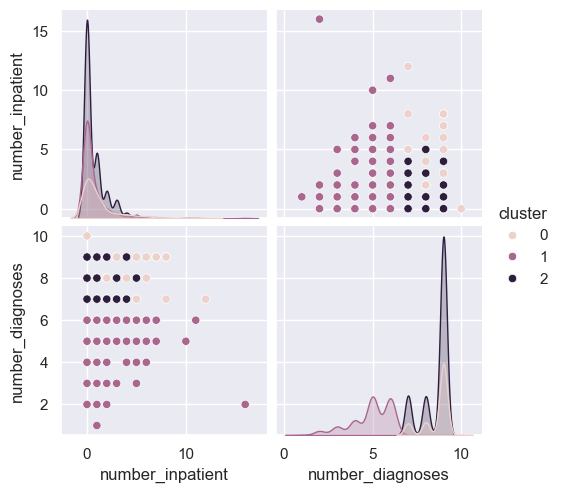

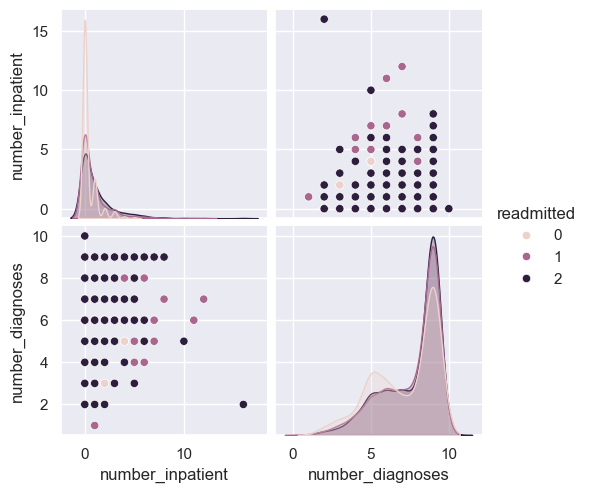

Dunn Index (Combined Data): 0.008481097123714733


In [41]:

# Number of clusters (3 classes of readmissions)
n_clusters = 3

# Fit KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_selected)

# Add cluster labels to the dataset
balanced_df['cluster'] = clusters

# Calculate silhouette score
silhouette_avg = silhouette_score(X_selected, clusters)
print(f"Silhouette Score: {silhouette_avg}")

# Calculate Davies-Bouldin score
davies_bouldin_avg = davies_bouldin_score(X_selected, clusters)
print(f"Davies-Bouldin Score: {davies_bouldin_avg}")

# Analyze the clusters
cluster_analysis = balanced_df.groupby('cluster')['readmitted'].value_counts(normalize=True).unstack()
print(cluster_analysis)

# Use selected_features for visualization
corrected_feature_names = selected_features

# Filter numeric features for pairplot
numeric_feature_names = [name for name in corrected_feature_names if balanced_df[name].dtype in ['int64', 'float64']]

# Visualize the clusters
sns.pairplot(balanced_df, hue='cluster', vars=numeric_feature_names[:4])  # Visualize using first 4 numeric features
plt.show()

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_selected)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = clusters
pca_df['readmitted'] = balanced_df['readmitted']

# Plot PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='viridis', s=100, alpha=0.7)
plt.title('PCA of Clusters')
plt.show()

# Plot PCA results with readmitted labels
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='readmitted', palette='viridis', s=100, alpha=0.7)
plt.title('PCA of Readmitted Labels')
plt.show()

figure, correlation_matrix = plot_pca_correlation_graph(
    X_selected, 
    selected_features, 
    dimensions=(1, 2),
    figure_axis_size=10,
)
# Change the font size of the labels
for text in figure.axes[0].texts:
    text.set_fontsize(10) 

plt.show()
print(correlation_matrix)

# Visualize the clusters with all numeric features
sns.pairplot(balanced_df, hue='cluster', vars=numeric_feature_names)
plt.show()

# Visualize the clusters with readmitted labels
sns.pairplot(balanced_df, hue='readmitted', vars=numeric_feature_names)
plt.show()

# Compute the Dunn Index for both clustering results
dunn_pca = dunn_index(np.array(X_pca), clusters)

print(f"Dunn Index (Combined Data): {dunn_pca}")

### RESTART FOR BETTER HANDLING

In [44]:
def setup_again():
    # Load the dataset
    df = pd.read_csv(r"diabetic_data.csv", na_values='?', low_memory=False)  # Treat '?' as NaN
    df = df.sample(frac=0.05, random_state=42)

    # Convert the `readmitted` column into numeric form
    readmitted_mapping = {'NO': 0, '<30': 2, '>30': 1}
    df['readmitted'] = df['readmitted'].map(readmitted_mapping)

    # Drop any rows with missing values in 'readmitted'
    df = df.dropna(subset=['readmitted'])

    # Determine the class with the smallest number of samples (minority class)
    class_counts = df['readmitted'].value_counts()
    minority_class_size = class_counts.min()

    # Downsample each class to the size of the minority class
    balanced_dfs = []
    for class_label, count in class_counts.items():
        class_subset = df[df['readmitted'] == class_label]
        downsampled_class = class_subset.sample(n=minority_class_size, random_state=42)
        balanced_dfs.append(downsampled_class)

    # Combine the downsampled classes into a single balanced dataset
    balanced_df = pd.concat(balanced_dfs, axis=0).reset_index(drop=True)

    # Define columns
    cols_to_drop = ['weight','medical_specialty','chlorpropamide','acetohexamide','weight','tolbutamide',
        'acarbose','miglitol','troglitazone','tolazamide','examide','citoglipton',
        'glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone',
        'metformin-rosiglitazone','metformin-pioglitazone', 'diag_2', 'diag_3', 'race', 'gender','A1Cresult','repaglinide', 'nateglinide', 'glimepiride', 'glipizide', 'glyburide',
        'pioglitazone', 'rosiglitazone', 'payer_code',    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
        'num_medications', 'number_outpatient', 'number_emergency' ]

    X_num = [
        'number_inpatient', 'number_diagnoses'
    ]

    X_cat = [
        'age', 'max_glu_serum', 'metformin',
        'insulin', 'change', 'diabetesMed',
    ]

    X_diag = ['diag_1']

    # Drop unnecessary columns
    X = balanced_df.drop(cols_to_drop + ['readmitted'], axis=1)

    return balanced_df, X, X_diag, X_cat, X_num


In [45]:
balanced_df, X, X_diag, X_cat, X_num = setup_again()
# Handle missing values
X[X_num] = X[X_num].fillna(X[X_num].mean())
X[X_cat + X_diag] = X[X_cat + X_diag].fillna('Unknown')

# Standardize numerical columns
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X[X_num])

# Label encode categorical columns
label_encoders = {}
for col in X_cat + X_diag:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Combine scaled numerical and encoded categorical columns
X_combined = pd.concat([pd.DataFrame(X_num_scaled, columns=X_num), X[X_cat + X_diag]], axis=1)

# Define range for number of clusters and PCA components
cluster_range = range(2, 11)
pca_components_range = range(2, 9)

# Initialize variables to store the best scores and corresponding number of clusters and PCA components
best_silhouette_combined = -1
best_davies_bouldin_combined = float('inf')
best_clusters_combined = 0

best_silhouette_pca = -1
best_davies_bouldin_pca = float('inf')
best_clusters_pca = 0
best_pca_components = 0

# Loop through the range of cluster numbers
for n_clusters in cluster_range:
    # Apply K-Prototypes with n_clusters on original combined data
    kproto = KPrototypes(n_clusters=n_clusters, random_state=42)
    clusters_combined = kproto.fit_predict(X_combined, categorical=[X_combined.columns.get_loc(col) for col in X_cat + X_diag])
    
    # Evaluate the clustering for original combined data
    silhouette_combined = silhouette_score(X_combined, clusters_combined)
    davies_bouldin_combined = davies_bouldin_score(X_combined, clusters_combined)
    
    # Update the best scores and corresponding number of clusters if the current scores are better
    if silhouette_combined > best_silhouette_combined:
        best_silhouette_combined = silhouette_combined
        best_clusters_combined = n_clusters
    if davies_bouldin_combined < best_davies_bouldin_combined:
        best_davies_bouldin_combined = davies_bouldin_combined
        best_clusters_combined = n_clusters
    
    # Loop through the range of PCA components
    for n_components in pca_components_range:
        # Apply PCA for dimensionality reduction
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X_combined)
        
        # Apply KMeans with n_clusters on PCA-transformed data
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        clusters_pca = kmeans.fit_predict(X_pca)
        
        # Evaluate the clustering for PCA-transformed data
        silhouette_pca = silhouette_score(X_pca, clusters_pca)
        davies_bouldin_pca = davies_bouldin_score(X_pca, clusters_pca)
        
        # Update the best scores and corresponding number of clusters and PCA components if the current scores are better
        if silhouette_pca > best_silhouette_pca:
            best_silhouette_pca = silhouette_pca
            best_clusters_pca = n_clusters
            best_pca_components = n_components
        if davies_bouldin_pca < best_davies_bouldin_pca:
            best_davies_bouldin_pca = davies_bouldin_pca
            best_clusters_pca = n_clusters
            best_pca_components = n_components

# Print the best scores and corresponding number of clusters and PCA components
print(f'Best Silhouette Score (Combined): {best_silhouette_combined} with {best_clusters_combined} clusters')
print(f'Best Davies-Bouldin Index (Combined): {best_davies_bouldin_combined} with {best_clusters_combined} clusters')
print(f'Best Silhouette Score (PCA): {best_silhouette_pca} with {best_clusters_pca} clusters and {best_pca_components} PCA components')
print(f'Best Davies-Bouldin Index (PCA): {best_davies_bouldin_pca} with {best_clusters_pca} clusters and {best_pca_components} PCA components')

Best Silhouette Score (Combined): 0.006310403464444765 with 5 clusters
Best Davies-Bouldin Index (Combined): 29.52176386756556 with 5 clusters
Best Silhouette Score (PCA): 0.6295044866833189 with 3 clusters and 2 PCA components
Best Davies-Bouldin Index (PCA): 0.43924185170486396 with 3 clusters and 2 PCA components


Silhouette Score (Combined): -0.03327051050731438
Davies-Bouldin Index (Combined): 29.52176386756556
Silhouette Score (PCA): 0.629504486683319
Davies-Bouldin Index (PCA): 0.4392418517048637


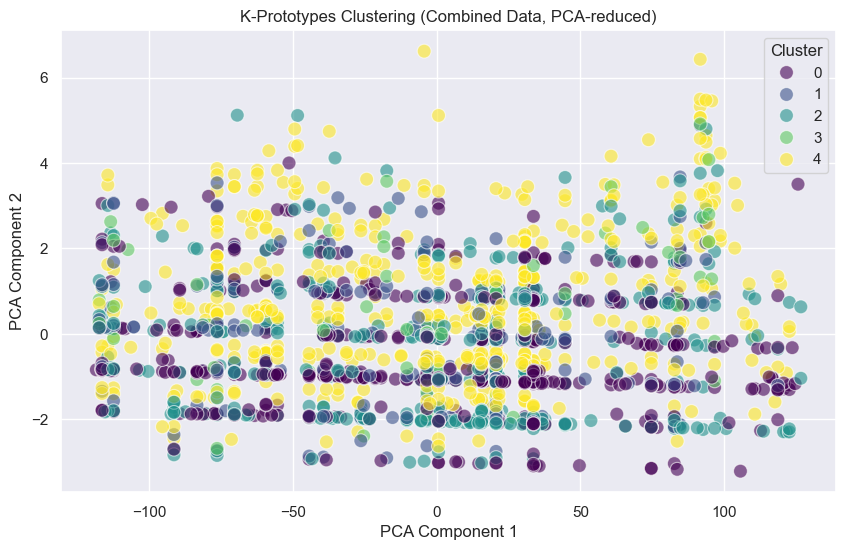

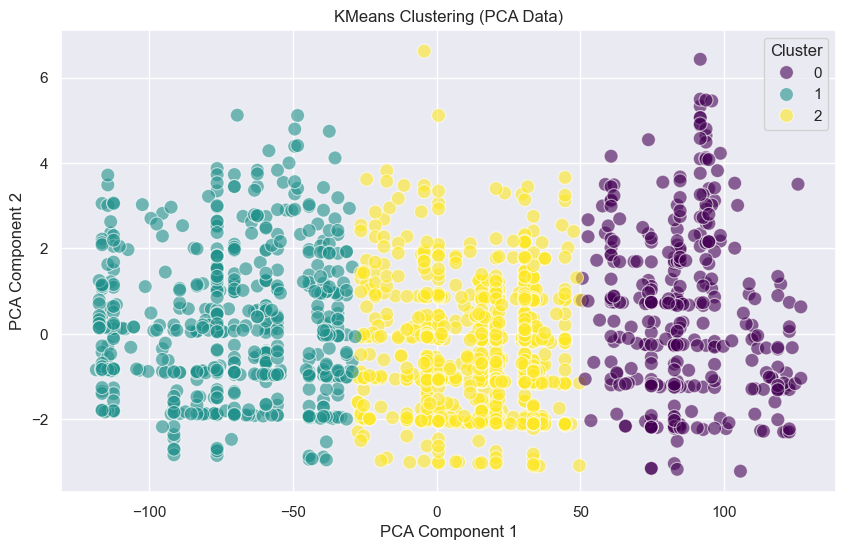

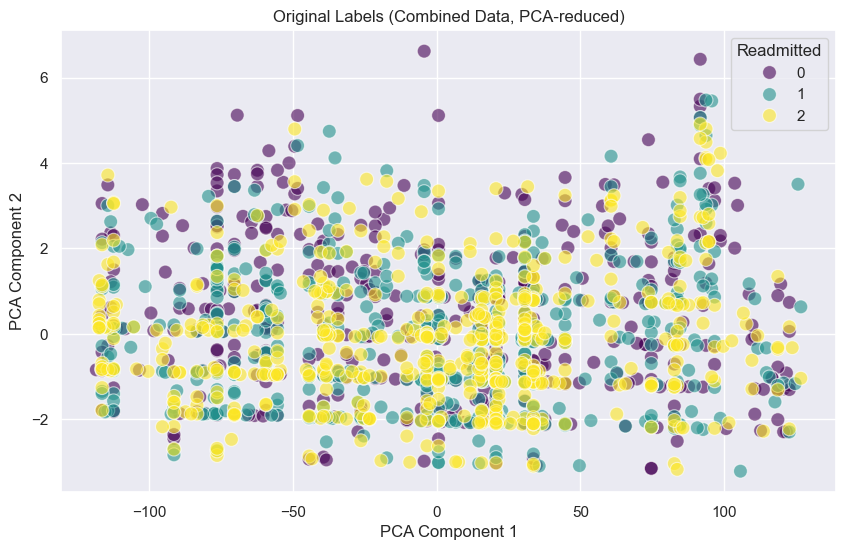

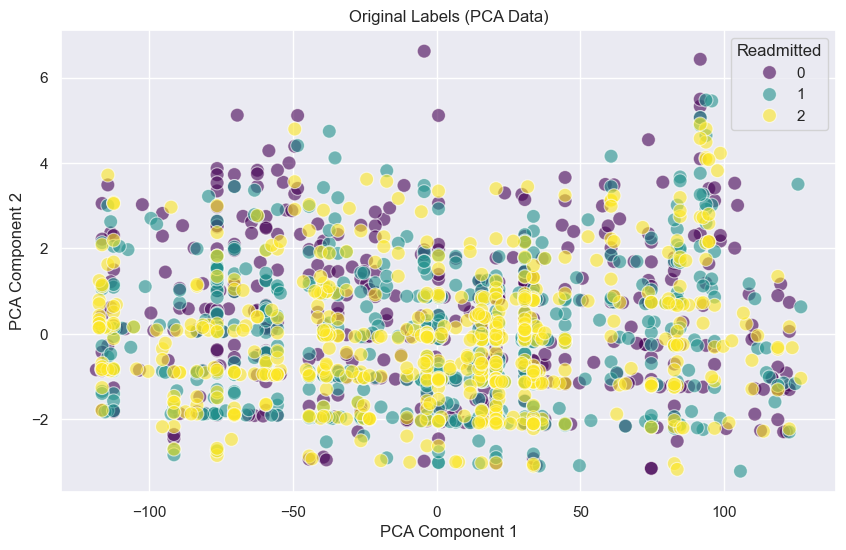

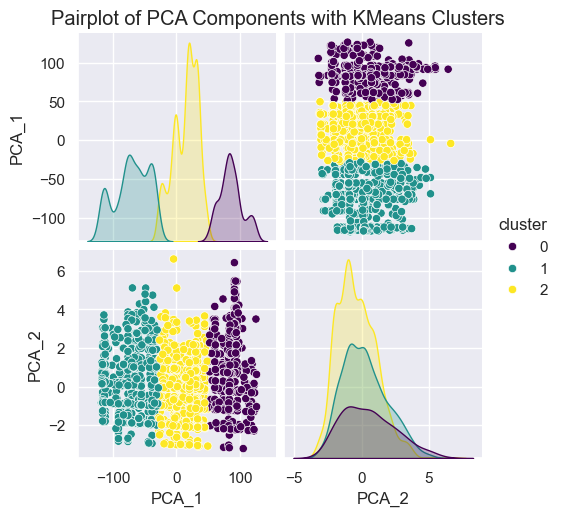

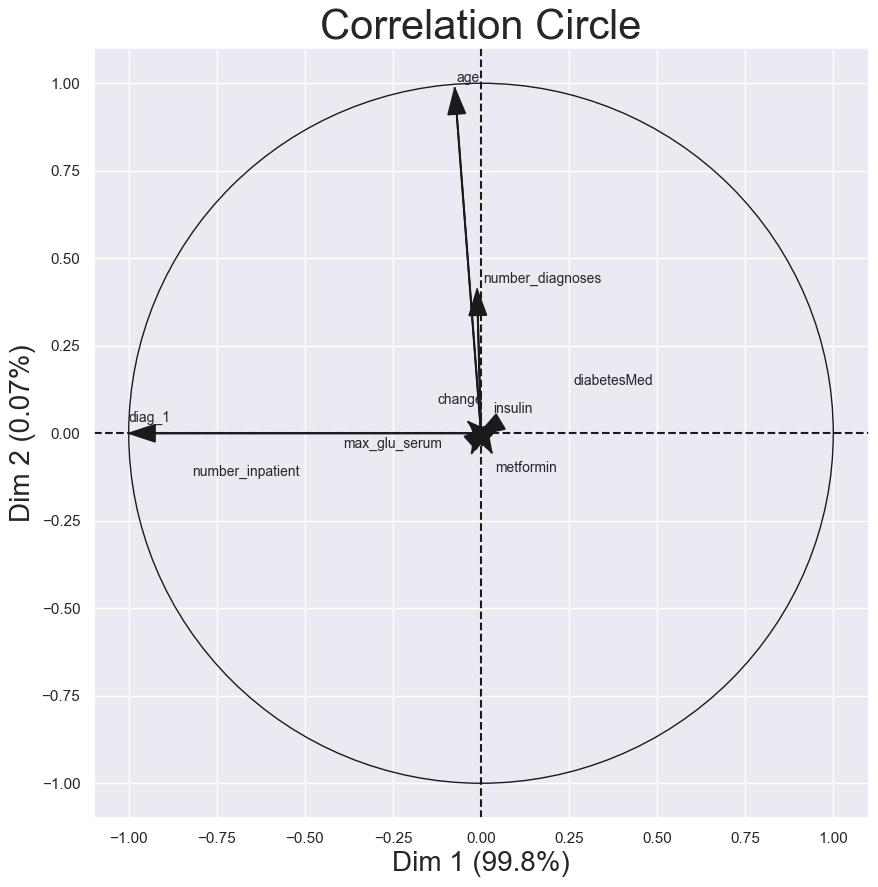

                     Dim 1     Dim 2
number_inpatient -0.026336 -0.056859
number_diagnoses -0.011121  0.411661
age              -0.074516  0.986657
max_glu_serum    -0.008654 -0.005189
metformin         0.030720 -0.055695
insulin           0.024898  0.022515
change           -0.036554  0.032868
diabetesMed       0.051911  0.017312
diag_1           -1.000000 -0.000054


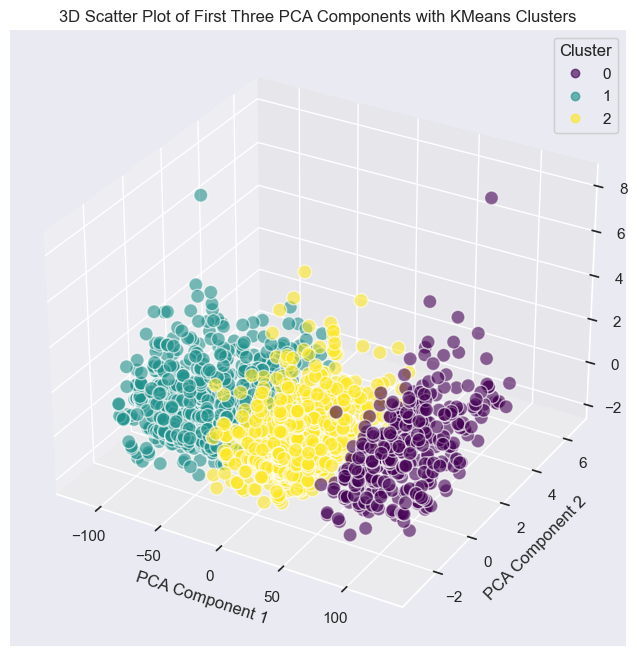

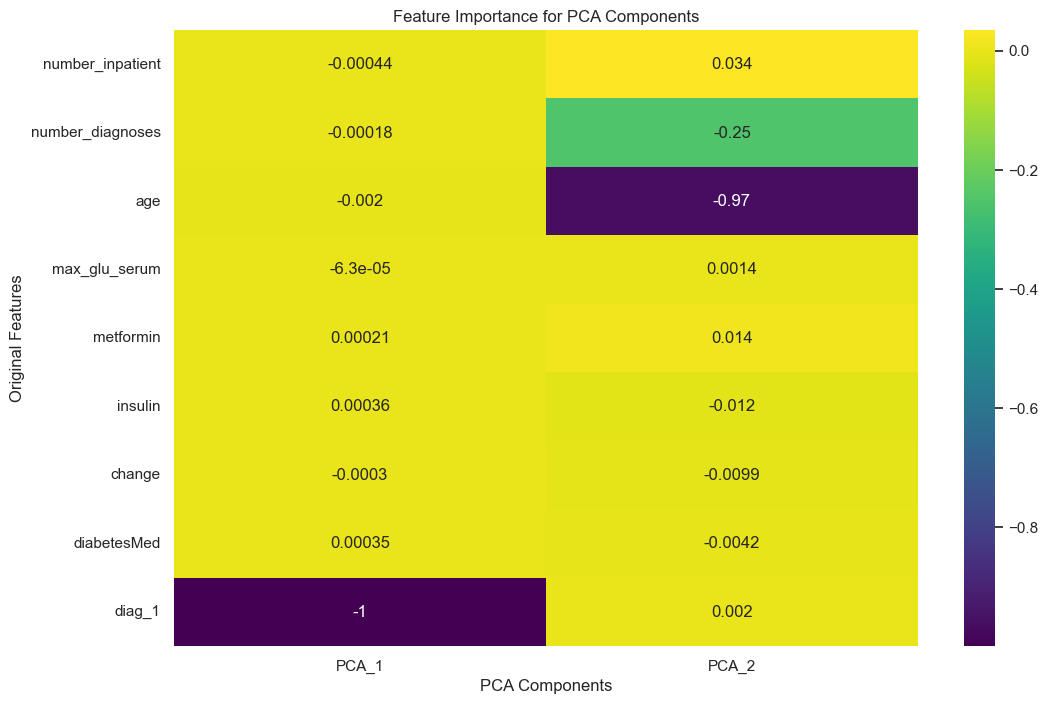

Dunn Index (Combined Data): 0.0021675626078078852
Dunn Index (PCA Data): 0.011117401433698776


In [46]:
balanced_df, X, X_diag, X_cat, X_num = setup_again()

# Handle missing values
X[X_num] = X[X_num].fillna(X[X_num].mean())
X[X_cat + X_diag] = X[X_cat + X_diag].fillna('Unknown')

# Standardize numerical columns
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X[X_num])

# Label encode categorical columns
label_encoders = {}
for col in X_cat + X_diag:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Combine scaled numerical and encoded categorical columns
X_combined = pd.concat([pd.DataFrame(X_num_scaled, columns=X_num), X[X_cat + X_diag]], axis=1)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined)

# Apply K-Prototypes with 3 clusters on original combined data
kproto = KPrototypes(n_clusters=5, random_state=42)
clusters_combined = kproto.fit_predict(X_combined, categorical=[X_combined.columns.get_loc(col) for col in X_cat + X_diag])

# Add cluster labels to the dataframe for original combined data
balanced_df['cluster_combined'] = clusters_combined

# Evaluate the clustering for original combined data
silhouette_combined = silhouette_score(X_combined, clusters_combined)
davies_bouldin_combined = davies_bouldin_score(X_combined, clusters_combined)
#dunn_combined = dunn(X_combined, clusters_combined)
print(f'Silhouette Score (Combined): {silhouette_combined}')
print(f'Davies-Bouldin Index (Combined): {davies_bouldin_combined}')
#print(f'Dunn Index (Combined): {dunn_combined}')

# Apply KMeans with 3 clusters on PCA-transformed data
kmeans = KMeans(n_clusters=3, random_state=42)
clusters_pca = kmeans.fit_predict(X_pca)

# Add cluster labels to the dataframe for PCA-transformed data
balanced_df['cluster_pca'] = clusters_pca

# Evaluate the clustering for PCA-transformed data
silhouette_pca = silhouette_score(X_pca, clusters_pca)
davies_bouldin_pca = davies_bouldin_score(X_pca, clusters_pca)
#dunn_pca = dunn(X_pca, clusters_pca)
print(f'Silhouette Score (PCA): {silhouette_pca}')
print(f'Davies-Bouldin Index (PCA): {davies_bouldin_pca}')
#print(f'Dunn Index (PCA): {dunn_pca}')

# Plot the clusters for original combined data
pca_2d_combined = PCA(n_components=2)
X_pca_2d_combined = pca_2d_combined.fit_transform(X_combined)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca_2d_combined[:, 0], y=X_pca_2d_combined[:, 1], hue=clusters_combined, palette='viridis', s=100, alpha=0.6, edgecolor='w')
plt.title('K-Prototypes Clustering (Combined Data, PCA-reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# Plot the clusters for PCA-transformed data
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters_pca, palette='viridis', s=100, alpha=0.6, edgecolor='w')
plt.title('KMeans Clustering (PCA Data)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# Plot the original labels for original combined data
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca_2d_combined[:, 0], y=X_pca_2d_combined[:, 1], hue=balanced_df['readmitted'], palette='viridis', s=100, alpha=0.6, edgecolor='w')
plt.title('Original Labels (Combined Data, PCA-reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Readmitted')
plt.show()

# Plot the original labels for PCA-transformed data
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=balanced_df['readmitted'], palette='viridis', s=100, alpha=0.6, edgecolor='w')
plt.title('Original Labels (PCA Data)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Readmitted')
plt.show()

# Pairplot for PCA-transformed data with KMeans clusters
pca_df = pd.DataFrame(X_pca, columns=[f'PCA_{i+1}' for i in range(X_pca.shape[1])])
pca_df['cluster'] = clusters_pca
sns.pairplot(pca_df, hue='cluster', palette='viridis')
plt.suptitle('Pairplot of PCA Components with KMeans Clusters', y=1.02)
plt.show()

# Define selected features for PCA correlation graph
selected_features = X_num + X_cat + X_diag

# **Fix: Pass the original data to `X_original` parameter**
figure, correlation_matrix = plot_pca_correlation_graph(
    X_combined, 
    selected_features, 
    dimensions=(1, 2),
    figure_axis_size=10,
)
# Change the font size of the labels
for text in figure.axes[0].texts:
    text.set_fontsize(10) 

plt.show()
print(correlation_matrix)

# 3D scatter plot for the first three PCA components with KMeans clusters
# **Ensure PCA has at least 3 components**
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_combined)
pca_df_3d = pd.DataFrame(X_pca_3d, columns=[f'PCA_{i+1}' for i in range(X_pca_3d.shape[1])])
pca_df_3d['cluster'] = clusters_pca  # Use clusters from earlier or recompute if needed

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df_3d['PCA_1'], pca_df_3d['PCA_2'], pca_df_3d['PCA_3'], c=pca_df_3d['cluster'], cmap='viridis', s=100, alpha=0.6, edgecolor='w')
legend1 = ax.legend(*scatter.legend_elements(), title="Cluster")
ax.add_artist(legend1)
ax.set_title('3D Scatter Plot of First Three PCA Components with KMeans Clusters')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.show()

# Plot feature importance for PCA components
pca_components = pd.DataFrame(pca.components_, columns=selected_features, index=[f'PCA_{i+1}' for i in range(pca.n_components_)])
plt.figure(figsize=(12, 8))
sns.heatmap(pca_components.T, cmap='viridis', annot=True)
plt.title('Feature Importance for PCA Components')
plt.xlabel('PCA Components')
plt.ylabel('Original Features')
plt.show()

# Compute the Dunn Index for both clustering results
dunn_combined = dunn_index(np.array(X_combined), clusters_combined)
dunn_pca = dunn_index(np.array(X_pca), clusters_pca)

print(f"Dunn Index (Combined Data): {dunn_combined}")
print(f"Dunn Index (PCA Data): {dunn_pca}")


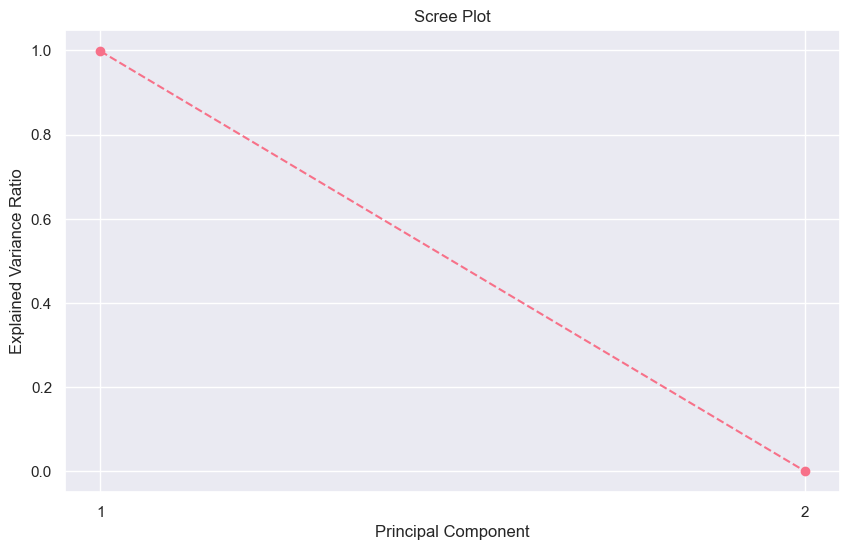

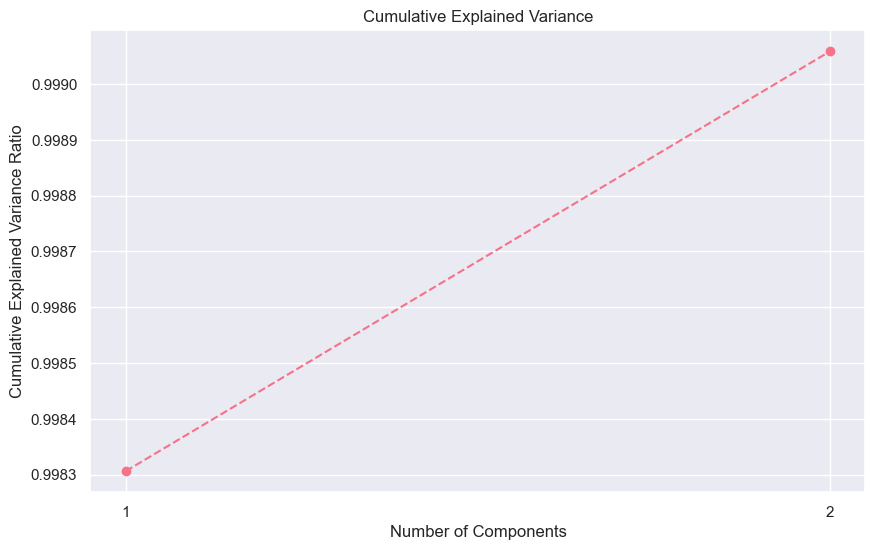

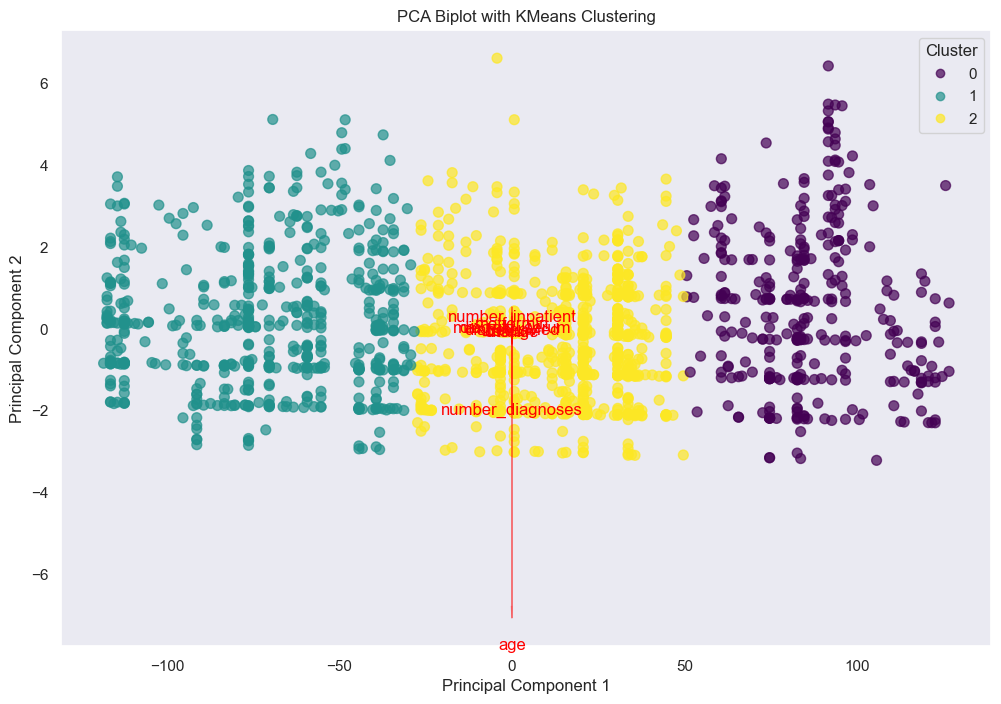

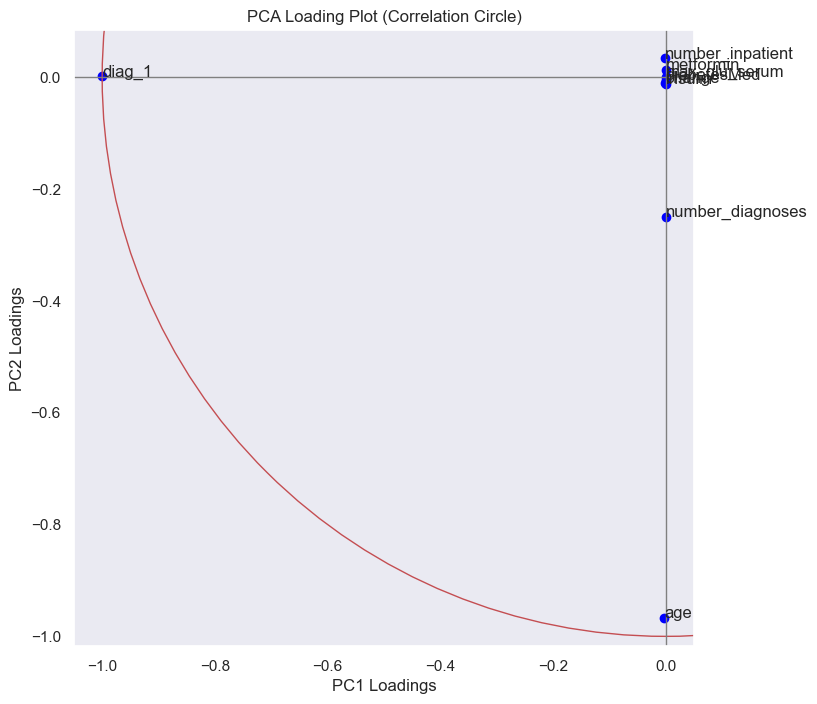

In [47]:
# Plot the explained variance ratio of the PCA components
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.show()

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.show()

# Create a biplot of the first two principal components
plt.figure(figsize=(12, 8))

# Plot the projected data points with cluster labels
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_pca, cmap='viridis', s=50, alpha=0.7)
plt.title('PCA Biplot with KMeans Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Plot the loading vectors (coefficients of the original features)
feature_vectors = pca.components_.T
arrow_size, text_pos = 7, 8  # Scaling factors for arrows and text
for i, v in enumerate(feature_vectors):
    plt.arrow(0, 0, v[0]*arrow_size, v[1]*arrow_size, color='red', alpha=0.5, head_width=0.2)
    plt.text(v[0]*text_pos, v[1]*text_pos, selected_features[i], color='red', ha='center', va='center')

# Create a legend for clusters
plt.legend(*scatter.legend_elements(), title='Cluster')
plt.grid()
plt.show()

# Extract the loadings for the first two principal components
loadings = pca.components_.T[:, :2]

# Create a DataFrame for the loadings
loadings_df = pd.DataFrame(loadings, columns=['PC1', 'PC2'])
loadings_df['variable'] = selected_features

# Plot the correlation circle
plt.figure(figsize=(8, 8))
plt.scatter(loadings_df['PC1'], loadings_df['PC2'], color='blue')

# Draw the unit circle
circle = plt.Circle((0, 0), 1, color='r', fill=False)
plt.gca().add_artist(circle)

# Annotate the variables
for i, variable in enumerate(loadings_df['variable']):
    plt.annotate(variable, (loadings_df['PC1'][i], loadings_df['PC2'][i]))

plt.xlabel('PC1 Loadings')
plt.ylabel('PC2 Loadings')
plt.title('PCA Loading Plot (Correlation Circle)')
plt.grid()
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.show()